# Music genre prediction

## Описание  задачи

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

## Описание данных

    instance_id - уникальный идентификатор трека  
    track_name - название трека  
    acousticness - акустичность   
    danceability - танцевальность  
    duration_ms -продолжительность в милисекундах  
    energy - энергичность  
    instrumentalness - инструментальность  
    key - базовый ключ (нота) произведения  
    liveness - привлекательность  
    loudness - громкость  
    mode - указывает на модальность (мажорную или минорную) трека  
    speechiness - выразительность  
    tempo - темп  
    obtained_date - дата загрузки в сервис  
    valence - привлекательность произведения для пользователей сервиса  
    music_genre - музыкальный жанр  

## Citation
Eduard Grigoryan, Eugene. (2023). Music genre prediction [M1_23DS+]. Kaggle. https://kaggle.com/competitions/music-genre-prediction-m1-23ds

Загрузим библиотеки

In [46]:
import pandas as pd
import numpy as np
import time
import seaborn as se
import matplotlib.pyplot as plt



#Метрики и оценки
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, \
                balanced_accuracy_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

#Работа с текстом
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD

#Модели
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#upsampling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE



#Phik
import random
import phik
from phik import resources, report
from phik.report import correlation_report, plot_correlation_matrix


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,  LabelEncoder, PowerTransformer, RobustScaler
from category_encoders import LeaveOneOutEncoder

#Модели для определения языка
from langdetect import detect, DetectorFactory, detect_langs
DetectorFactory.seed = 0
from guess_language import guess_language
import langid
import fasttext
model = fasttext.load_model('lid.176.bin')

import warnings
warnings.filterwarnings("ignore")

In [47]:
#Настройка графиков
se.set_style('darkgrid')
#%config InlineBackend.figure_formats = 'png' # svg Не работает :(
se.set(rc={'font.size': 8, 
           'figure.facecolor': 'white',
           'figure.figsize': (10, 6),
           'axes.edgecolor': 'black',
           'axes.facecolor': 'white',
           'axes.grid': True,
           'grid.color': 'black',
           'grid.linewidth': 0.5,
           'grid.alpha': 0.3,
           'grid.linestyle': '--',
           'text.color': 'black',
           'xtick.color': 'black',
           'ytick.color': 'black',
           'font.size': 10.0,
           'xtick.bottom': True,
           'xtick.top': False,
           'ytick.left': True,
           'ytick.right': True,
           'lines.linewidth': 1, 
           'patch.edgecolor': 'w',
           'lines.solid_capstyle': 'butt',
           'patch.linewidth': 0.2})

# EDA

## Загрузка и предварительный анализ данных

In [48]:
try:
    train_data = pd.read_csv("data/kaggle_music_genre_train.csv")
    test_data = pd.read_csv("data/kaggle_music_genre_test.csv")
except:
    print("Не удалось загрузить данные!!!")

In [49]:
train_data.head()

instance_id                  track_name  acousticness  danceability  \
0      25143.0                  Highwayman        0.4800         0.670   
1      26091.0       Toes Across The Floor        0.2430         0.452   
2      87888.0       First Person on Earth        0.2280         0.454   
3      77021.0  No Te Veo - Digital Single        0.0558         0.847   
4      20852.0             Chasing Shadows        0.2270         0.742   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0     182653.0   0.351          0.017600   D     0.115   -16.842  Major   
1     187133.0   0.670          0.000051   A     0.108    -8.392  Minor   
2     173448.0   0.804          0.000000   E     0.181    -5.225  Minor   
3     255987.0   0.873          0.000003  G#     0.325    -4.805  Minor   
4     195333.0   0.575          0.000002   C     0.176    -5.550  Major   

   speechiness    tempo obtained_date  valence  music_genre  
0       0.0463  101.384         4-Apr    0.450      Country  
1       0.0352  113.071         4-Apr    0.539         Rock  
2       0.3710   80.980         4-Apr    0.344  Alternative  
3       0.0804  116.007         4-Apr    0.966      Hip-Hop  
4       0.0487   76.494         4-Apr    0.583  Alternative

In [50]:
#Проверим, есть ли повторения среди id песен:
print("Являются ли значения id уникальными для всех строк:", len(train_data['instance_id'].unique()) == len(train_data))

Являются ли значения id уникальными для всех строк: True


### Название трека

Название трека может быть очень сильными признаком. Оно может много сказать о самой песне. Попробуем немного поисследовать этот признак. 

In [51]:
#train_data['track_name'].tolist()

['Highwayman',
 'Toes Across The Floor',
 'First Person on Earth',
 'No Te Veo - Digital Single',
 'Chasing Shadows',
 'Eskimo Blue Day - Remastered',
 'Living On My Own',
 'Para Machuchar Meu Coracao',
 'In the Mood',
 '20.000 Volts',
 'Blessings',
 'Up Above My Head',
 'Witchy Woman - Eagles 2013 Remaster',
 'Iwanakutemo Tsutawaru Arewa Sukoshi Usoda - All Time Best Version',
 'School - Remastered',
 'Let Go Today',
 'Flying Saucer',
 'Muevelo',
 'Ill Ray (The King)',
 "That's What It's All About",
 'LVL',
 'Rebels - G-REX Remix',
 "Still Don't Give A Fuck",
 'Kindhearted Woman Blues',
 "Stroker's Theme",
 'X (with 2 Chainz & Saudi)',
 'Serenade in B flat, K.361 "Gran partita": 3. Adagio',
 'Samba Tranquille',
 'Real',
 'Money Don’t Change You',
 'Flare Guns',
 'Let Your Love Flow',
 'Wade in the Water - Live',
 "Country Boy's World",
 'Life Is Confusing',
 'Flodgin',
 'Dreaming with My Eyes Open',
 'Starfruit LA',
 'The Game',
 'No Less',
 'Down to Mexico',
 'Just A Friend',
 'Lost 

Предворительно можно получить следующие признаки:  

    1)Количество символов в названии  
    2)Количесвто слов
    3)Примерно определить язык названия
    4)Использовать CountVectorizer для определния частых слов
    5)Использовать TfidfVectorizer совместно с сингулярным разложением TSVD

Очистим названия от лишних символов

In [52]:
def track_name_cleaner(data):
    data['track_name'] = data['track_name'].str.replace('-', '')
    data['track_name'] = data['track_name'].str.replace('.', '')
    data['track_name'] = data['track_name'].str.replace('  ', ' ')
    data['track_name'] = data['track_name'].str.replace('(', '')
    data['track_name'] = data['track_name'].str.replace(')', '')
    data['track_name'] = data['track_name'].str.replace(':', '')
    data['track_name'] = data['track_name'].str.replace(',', '')
    data['track_name'] = data['track_name'].str.replace('&', '')
    data['track_name'] = data['track_name'].str.replace('/', '')
    data['track_name'] = data['track_name'].str.replace('?', '')
    return data

#### CountVectorizer

Попробуем определить, есть ли смысл использования CountVectorizer

In [53]:
CVec =  CountVectorizer(max_features=10, min_df=5, max_df=1.0, stop_words=['english']) 
track_name_features_cv = CVec.fit_transform(train_data['track_name']).toarray() 

In [54]:
target_ohe_for_headplot = pd.get_dummies(train_data['music_genre'])

<AxesSubplot:>

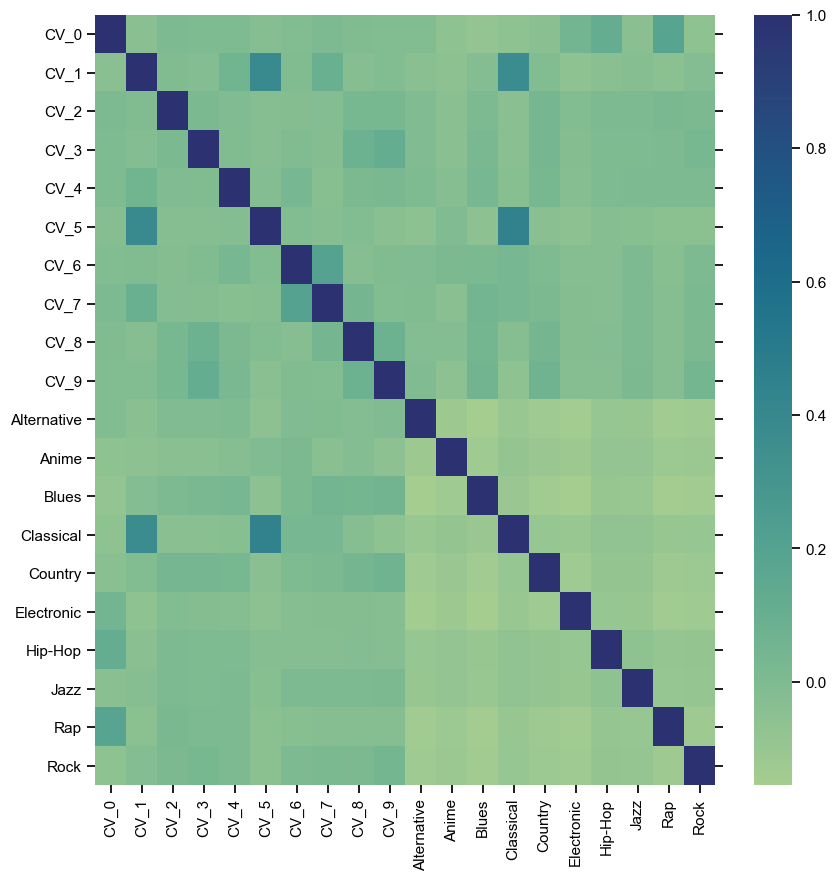

In [55]:
plt.subplots(figsize=(10, 10))
se.heatmap(pd.concat([pd.DataFrame(track_name_features_cv, columns=[f'CV_{i}' for i in range(10)]), 
                      target_ohe_for_headplot], axis=1).corr(), cmap="crest")

In [56]:
def generate_count_vectot_features(data, test, count=10):
    CVec =  CountVectorizer(max_features=count, min_df=5, max_df=1.0, stop_words=['english']) 
    data_cv = pd.DataFrame(CVec.fit_transform(data['track_name']).toarray(), columns=[f'CV_{i}' for i in range(count)] )
    test_cv = pd.DataFrame(CVec.transform(test['track_name']).toarray(), columns=[f'CV_{i}' for i in range(count)]  )
    
    data = pd.concat([data, data_cv], axis=1)
    test = pd.concat([test, test_cv], axis=1)
    return data, test

**Выводы**: 

Использование CountVectorizer вряд ли даст прирост в метрике, но может увеличить точность в определнии одного жанра в подходах один против всех или один против одного

#### TfidfTransformer and MultinomialNB

Построим вспомогательную модель для определния жанра по названию трека. Это может дать дополнительный прирост в точности. Но необходимо быть аккуратными и применить метод так, чтобы он не дал переобучения для тренировочной выборки. 

In [57]:
#Возвращает столбец с предсказаниями жанра для test, обученный по train, target
def Tfidf_NB(train, target, test):
    train = track_name_cleaner(train)
    test = track_name_cleaner(test)
    
    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(train['track_name'])
    test_counts = count_vect.transform(test['track_name'])
    
    tfidf_transformer = TfidfTransformer()
    train_tfidf = tfidf_transformer.fit_transform(train_counts)
    test_tfidf = tfidf_transformer.transform(test_counts)

    clf = MultinomialNB().fit(train_tfidf, target['music_genre'])
    pred = pd.DataFrame(clf.predict(test_tfidf))
    pred.columns = ['Tfidf_NB']
    return pred

In [58]:
pred = Tfidf_NB(train_data[:5000], train_data[:5000], train_data[5000:])

In [59]:
ans = 0
for i in range(len(pred)):
    if pred.iloc[i][0] == train_data[5000:].iloc[i]['music_genre']:
        ans+=1
        
round(ans/len(pred), 3)

0.249

#### TfidfVectorizer and TSVD

Векторизация  и уменьшение размерности

In [60]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_data['track_name'])

In [61]:
tsvd = TruncatedSVD(3, algorithm ='arpack')
a = tsvd.fit_transform(X)
a.shape

(20394, 3)

(-0.4, 0.6)

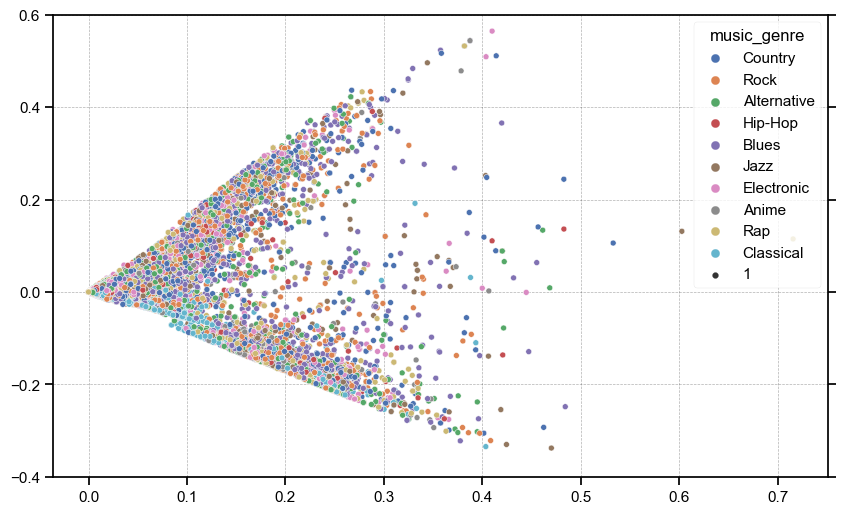

In [62]:
se.scatterplot(x=a[:,0], y=a[:,1], hue=train_data['music_genre'], size=1)
plt.ylim(-0.4, 0.6)

In [63]:
def TfV_TSVD_features(data, test, count=3):
    vectorizer = TfidfVectorizer()
    new_features_data_tfv = vectorizer.fit_transform(data['track_name'])
    new_features_test_tfv = vectorizer.transform(test['track_name'])
    
    tsvd = TruncatedSVD(3, algorithm ='arpack')
    new_features_data = pd.DataFrame(tsvd.fit_transform(new_features_data_tfv))
    new_features_test = pd.DataFrame(tsvd.transform(new_features_test_tfv))
    new_features_data.columns = [f'TfV_TSVD_{i}' for i in range(count)]
    new_features_test.columns = [f'TfV_TSVD_{i}' for i in range(count)]
    
    data = pd.concat([data, new_features_data], axis=1)
    test = pd.concat([test, new_features_test], axis=1)
    
    return data, test

#### TfV_TSVD_KMean

Кластеризация предыдущего пункта

In [64]:
def TfV_TSVD_kmean(data, test, n_clust = 20):
    columns = [col for col in data.columns if 'TfV_TSVD' in col]
    
    kmean = KMeans(n_clusters=n_clust, random_state=42)

    data_clust = pd.DataFrame(kmean.fit_predict(data[columns]), columns = ['kmean_TfV_TSVD'])
    test_clust = pd.DataFrame(kmean.predict(test[columns]), columns = ['kmean_TfV_TSVD'])

    data = data.join(data_clust, how='outer')
    test = test.join(test_clust, how='outer')
    
    data.columns = data.columns.astype(str)
    test.columns = test.columns.astype(str)

    return data, test

#### Определение языка

In [65]:
def upgrade_detect(x):
    try:
        return detect(x)
    except:
        return 'UNKNOWN'

In [66]:
def updrade_langid(x):
    return langid.classify(x)[0]

In [67]:
def fast_text(x):
    return model.predict(x)[0][0][-2:]

In [68]:
def detect_language(data):
    language = pd.DataFrame()
    language['langdetect_detect'] = data['track_name'].apply(upgrade_detect)
    language['guess_language'] = data['track_name'].apply(guess_language)
    language['updrade_langid'] = data['track_name'].apply(updrade_langid)
    language['fast_text'] = data['track_name'].apply(fast_text)
    
    language = language.mode(axis=1)
    language.loc[language.isna().sum(axis=1) == 0, 0] = 'UNKNOWN'
    
    language.drop(columns=[1,2,3], inplace=True)
    
    
    le = LabelEncoder()
    language = pd.DataFrame(le.fit_transform(language))
    language.columns = ['language']
    
    return pd.concat([data, language], axis=1)

### Признак **obtained_date**

In [69]:
train_data['obtained_date'].unique()

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr'], dtype=object)

Максимально неинформативный признак, в финальном датасете он участвовать не будет. Долой его.

In [70]:
train_data.drop(columns=['obtained_date'], inplace = True)
test_data.drop(columns=['obtained_date'], inplace = True)

Это неинформатиынй признак, удалим его

### Категориальные и числовые признаки

Сразу можно сказать, что есть категориальные и числовые признаки.  

**Категориальные**:  
    key, mode
    
**Числовые**:  
        acousticness, danceability, duration_ms, energy, instrumentalness, liveness,
       loudness, speechiness, tempo, valence
       
**Целевой признак**:  
        music_genre

In [71]:
#Пердворительно признаки для обучения
good_features = ['acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'valence',
       'music_genre']

In [72]:
#Числовые признаки
num_features = ['acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness',  'liveness',
       'loudness', 'speechiness', 'tempo', 'valence']
#Категориальные признаки
cat_features = ['key', 'mode']

### Целевой признак

In [73]:
train_data['music_genre'].unique()

array(['Country', 'Rock', 'Alternative', 'Hip-Hop', 'Blues', 'Jazz',
       'Electronic', 'Anime', 'Rap', 'Classical'], dtype=object)

In [74]:
balance_genres = train_data.groupby('music_genre')['instance_id'].count()
print("Процентное соотношение целевого признака в обучающем наборе:")
pd.DataFrame(balance_genres/len(train_data)*100).round(3).rename(columns={'instance_id': 'Процент данных'}) 

Процентное соотношение целевого признака в обучающем наборе:


Процент данных
music_genre                
Alternative          12.754
Anime                 9.321
Blues                14.014
Classical             6.732
Country              10.395
Electronic           12.572
Hip-Hop               5.614
Jazz                  6.075
Rap                  11.905
Rock                 10.616

### Ящик с усами

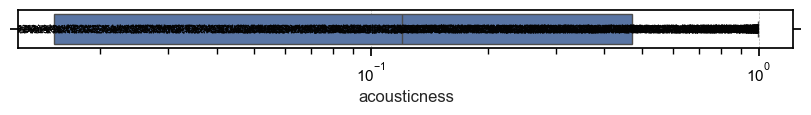

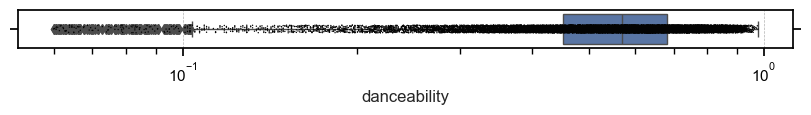

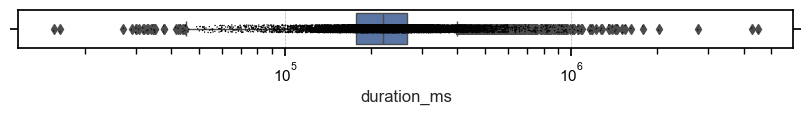

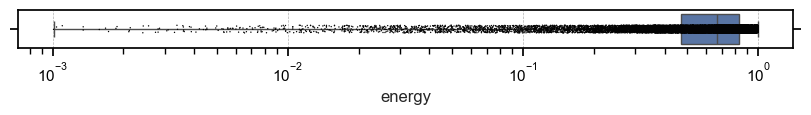

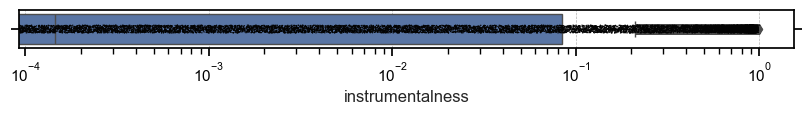

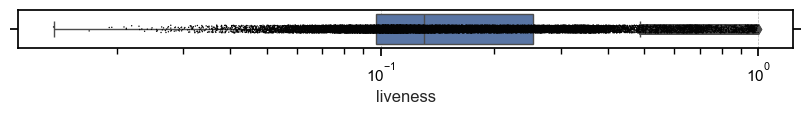

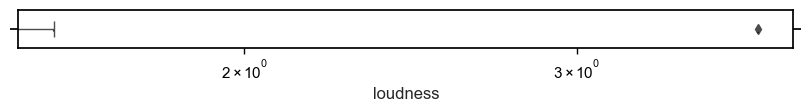

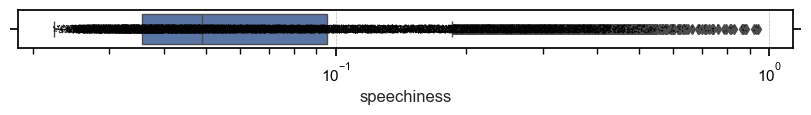

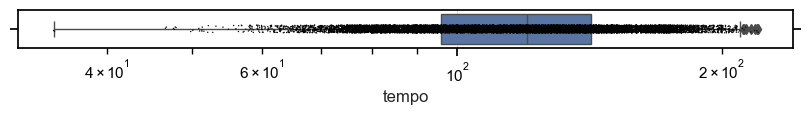

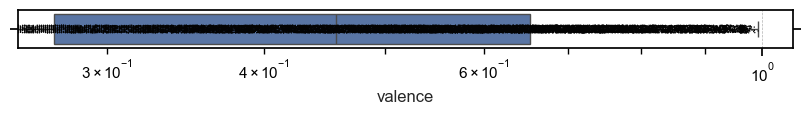

In [75]:
for i in num_features:
    f, ax = plt.subplots(figsize=(10, 0.5))
    ax.set_xscale("log")
    se.boxplot(x=i, data=train_data, ax=ax,  orient='h')
    se.stripplot(x=i, data=train_data, ax=ax,
              size=1, color=".01", linewidth=0)

Признак **loudness** показал странный результат. Посмотрим:

<AxesSubplot:>

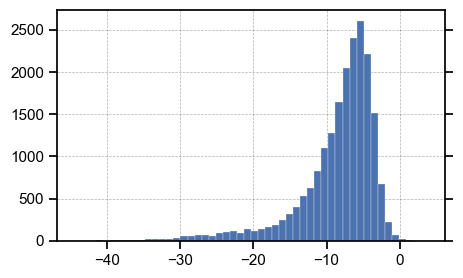

In [76]:
train_data['loudness'].hist(figsize=(5,3), bins=50)

Всё встало на свои места, log scale не работает в отрицательном диапазоне. На вский случай посмотрим на минимальние и максимальные значения по всем признакам.

In [77]:
train_data.describe()

instance_id  acousticness  danceability   duration_ms        energy  \
count  20394.000000  20394.000000  20394.000000  2.039400e+04  20394.000000   
mean   55973.846916      0.274783      0.561983  2.203754e+05      0.625276   
std    20695.792545      0.321643      0.171898  1.267283e+05      0.251238   
min    20011.000000      0.000000      0.060000 -1.000000e+00      0.001010   
25%    38157.250000      0.015200      0.451000  1.775170e+05      0.470000   
50%    56030.000000      0.120000      0.570000  2.195330e+05      0.666000   
75%    73912.750000      0.470000      0.683000  2.660000e+05      0.830000   
max    91758.000000      0.996000      0.978000  4.497994e+06      0.999000   

       instrumentalness      liveness      loudness   speechiness  \
count      20394.000000  20394.000000  20394.000000  20394.000000   
mean           0.159989      0.198540     -8.552998      0.091352   
std            0.306503      0.166742      5.499917      0.097735   
min            0.000000      0.013600    -44.406000      0.022300   
25%            0.000000      0.097300    -10.255750      0.035600   
50%            0.000144      0.130000     -7.052000      0.049050   
75%            0.084475      0.253000     -5.054000      0.095575   
max            0.996000      1.000000      3.744000      0.942000   

              tempo       valence  
count  19952.000000  20394.000000  
mean     120.942522      0.464588  
std       30.427590      0.243387  
min       34.765000      0.000000  
25%       95.921750      0.272000  
50%      120.012500      0.457000  
75%      141.966250      0.653000  
max      220.041000      0.992000

**Вывод**  
Ящик с усами показал, что в признаке **duration_ms** есть песни продолжительностью 74 минуты, а также со значениями -1, чего не может быть. Необходимо изучить это отдельно.

### Признак duration_ms

In [78]:
bad_data = train_data.query('duration_ms == -1')
print("Размер неполных данных", bad_data.shape)
bad_data.head()

Размер неполных данных (2009, 15)


instance_id                                         track_name  \
13      73565.0  Iwanakutemo Tsutawaru Arewa Sukoshi Usoda - Al...   
26      87453.0  Serenade in B flat, K.361 "Gran partita": 3. A...   
35      76827.0                                            Flodgin   
50      43888.0                              Things My Father Said   
55      39574.0  Fidelio, Op. 72, Act I: Ha! Welch ein Augenbli...   

    acousticness  danceability  duration_ms  energy  instrumentalness  key  \
13        0.1100         0.470         -1.0  0.6410          0.000000   F#   
26        0.9910         0.154         -1.0  0.0384          0.902000  NaN   
35        0.0848         0.748         -1.0  0.7120          0.000000    D   
50        0.0540         0.482         -1.0  0.6270          0.000003    D   
55        0.9090         0.374         -1.0  0.2270          0.000069   A#   

    liveness  loudness   mode  speechiness    tempo  valence  music_genre  
13     0.155    -7.454  Major       0.0658   86.387   0.6380        Anime  
26     0.109   -26.909  Major       0.0405   68.199   0.0393    Classical  
35     0.132    -5.651  Major       0.1430  140.055   0.1800          Rap  
50     0.111    -5.779  Major       0.0300   95.903   0.1700  Alternative  
55     0.686   -18.719  Major       0.0579   78.236   0.2640    Classical

Как оказалось, в существенной части данных отсутствует длина трека. Возможны три пути:  
        1)Заглушка на эти пропуски (оставить -1)  
        2)Парсинг  
        3)Не использовать данные для обучения  

In [79]:
train_data.sort_values(by='duration_ms', ascending = False).head()

instance_id                                         track_name  \
20117      31587.0                           Late Night Tales: Bonobo   
4502       33452.0                                         Mixtape 13   
8222       68269.0                                           45:33:00   
10699      44557.0  Mountain Jam (Theme From “First There Is A Mou...   
6343       33672.0  Symphony No. 6 in A Minor: 4. Finale (Allegro ...   

       acousticness  danceability  duration_ms  energy  instrumentalness key  \
20117       0.52800         0.408    4497994.0   0.436            0.0995   E   
4502        0.00299         0.366    4276000.0   0.778            0.0697   D   
8222        0.13800         0.478    2764934.0   0.897            0.6570   G   
10699       0.12300         0.332    2019293.0   0.741            0.7050  F#   
6343        0.94400         0.160    1778440.0   0.353            0.9020  A#   

       liveness  loudness   mode  speechiness    tempo  valence music_genre  
20117    0.1980   -11.497  Minor       0.1640   76.868   0.0778  Electronic  
4502     0.0954    -4.126  Major       0.0622  138.293   0.1470  Electronic  
8222     0.1000    -6.554  Major       0.0471  113.018   0.1860  Electronic  
10699    0.9420   -10.472  Minor       0.0535      NaN   0.2590       Blues  
6343     0.1050   -10.529  Major       0.0336   83.867   0.0716   Classical

In [80]:
train_data.query('duration_ms > 0').sort_values(by='duration_ms', ascending = True).head()

instance_id                                         track_name  \
4036       53111.0  Rinaldo, HWV 7a, Act I (Ed. G. Sechi): Questi ...   
3352       41093.0  St. John Passion, BWV 245, Pt. 2: No. 25c, Pil...   
11048      88575.0  Rinaldo, HWV 7a, Act II (Ed. G. Sechi): Esser ...   
11977      34105.0  Preludes, Op. 28: No. 10 in C-Sharp Minor (All...   
5946       34918.0                                     Gohan Vs. Cell   

       acousticness  danceability  duration_ms  energy  instrumentalness key  \
4036        0.96900         0.562      15509.0  0.1250           0.00138   B   
3352        0.91400         0.588      16316.0  0.1650           0.00000   D   
11048       0.96900         0.615      27179.0  0.1530           0.00000   B   
11977       0.99000         0.367      29040.0  0.0316           0.93900  F#   
5946        0.00291         0.338      30027.0  0.6310           0.86600   D   

       liveness  loudness   mode  speechiness    tempo  valence music_genre  
4036      0.373   -15.449  Minor       0.2010  115.827    0.574   Classical  
3352      0.233   -26.286  Major       0.2370  104.678    0.000   Classical  
11048     0.852   -20.561  Minor       0.4980   71.540    0.386   Classical  
11977     0.110   -31.053  Minor       0.0395  132.872    0.570   Classical  
5946      0.143    -7.465  Minor       0.0426  126.200    0.468       Anime

In [81]:
train_data = train_data.query('duration_ms < 2000000')

In [82]:
train_data.columns

Index(['instance_id', 'track_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'music_genre'],
      dtype='object')

In [83]:
train_data.shape

(20390, 15)

По правилам длинные композицииявляются выбросами, и могут повлиять на рещультаты масштабирования. Заодно отмасштабирую эти признаки

### Создание новых признаков

speechiness - выразитьельность, или же всё таки красноречивость?

In [84]:
# speech = ['Musical', 'Mix_music_speech', 'Speech']
# speech_bins = [train_data['speechiness'].min(), 0.33, 0.66, train_data['speechiness'].max()]

# train_data['speechiness_type'] = pd.cut(train_data['speechiness'], bins=speech_bins,
#                             labels=speech, right=True, include_lowest=True)

# test_data['speechiness_type'] = pd.cut(test_data['speechiness'], bins=speech_bins,
#                             labels=speech, right=True, include_lowest=True)

valence - привлекательность произведения для пользователей сервиса. Звучит как популярность. Меня начинает смущать описание признаков. 

In [85]:
# mood_labels = ['Sad', 'Normal', 'Happy']
# colToBin = train_data['valence']
# mood_bins = [colToBin.min(), colToBin.quantile(0.25), colToBin.quantile(0.75), colToBin.max()]

# #Изменим mode на modality, по смыслу так лучше
# train_data.rename(columns={'mode': 'modality'}, inplace=True)

# train_data['mood'] = pd.cut(train_data['valence'], bins=mood_bins, labels=mood_labels, right=True, include_lowest=True)

### Scaler

In [86]:
# scale = StandardScaler()

# train_data[['duration_ms', 'tempo']] = scale.fit_transform(train_data[['duration_ms', 'tempo']])
# test_data[['duration_ms', 'tempo']] = scale.transform(test_data[['duration_ms', 'tempo']])

### Корреляция phik

In [87]:
def phik_help(df):  
    
    # матрица корреляции признаков
    interval_cols = df.select_dtypes('number').columns.tolist()
    phik_overview = df.phik_matrix(interval_cols=interval_cols)
    
    plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1,
                        figsize=(15,15))

    # статистическая значимость зависимостей
    significance_overview = df.significance_matrix(interval_cols=interval_cols)
    
    plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1,
                        figsize=(15,15))

    # глобальный коэффициент корреляции
#     global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)

    
#     plot_correlation_matrix(global_correlation, 
#                             x_labels=[''], y_labels=global_labels, 
#                             color_map="Greens", title=r"$g_k$",
#                             fontsize_factor=1,
#                             figsize=(5,3))

In [88]:
a = pd.concat([train_data[:10000].drop(columns='music_genre'), pd.get_dummies(train_data[:10000]['music_genre'])], axis=1)

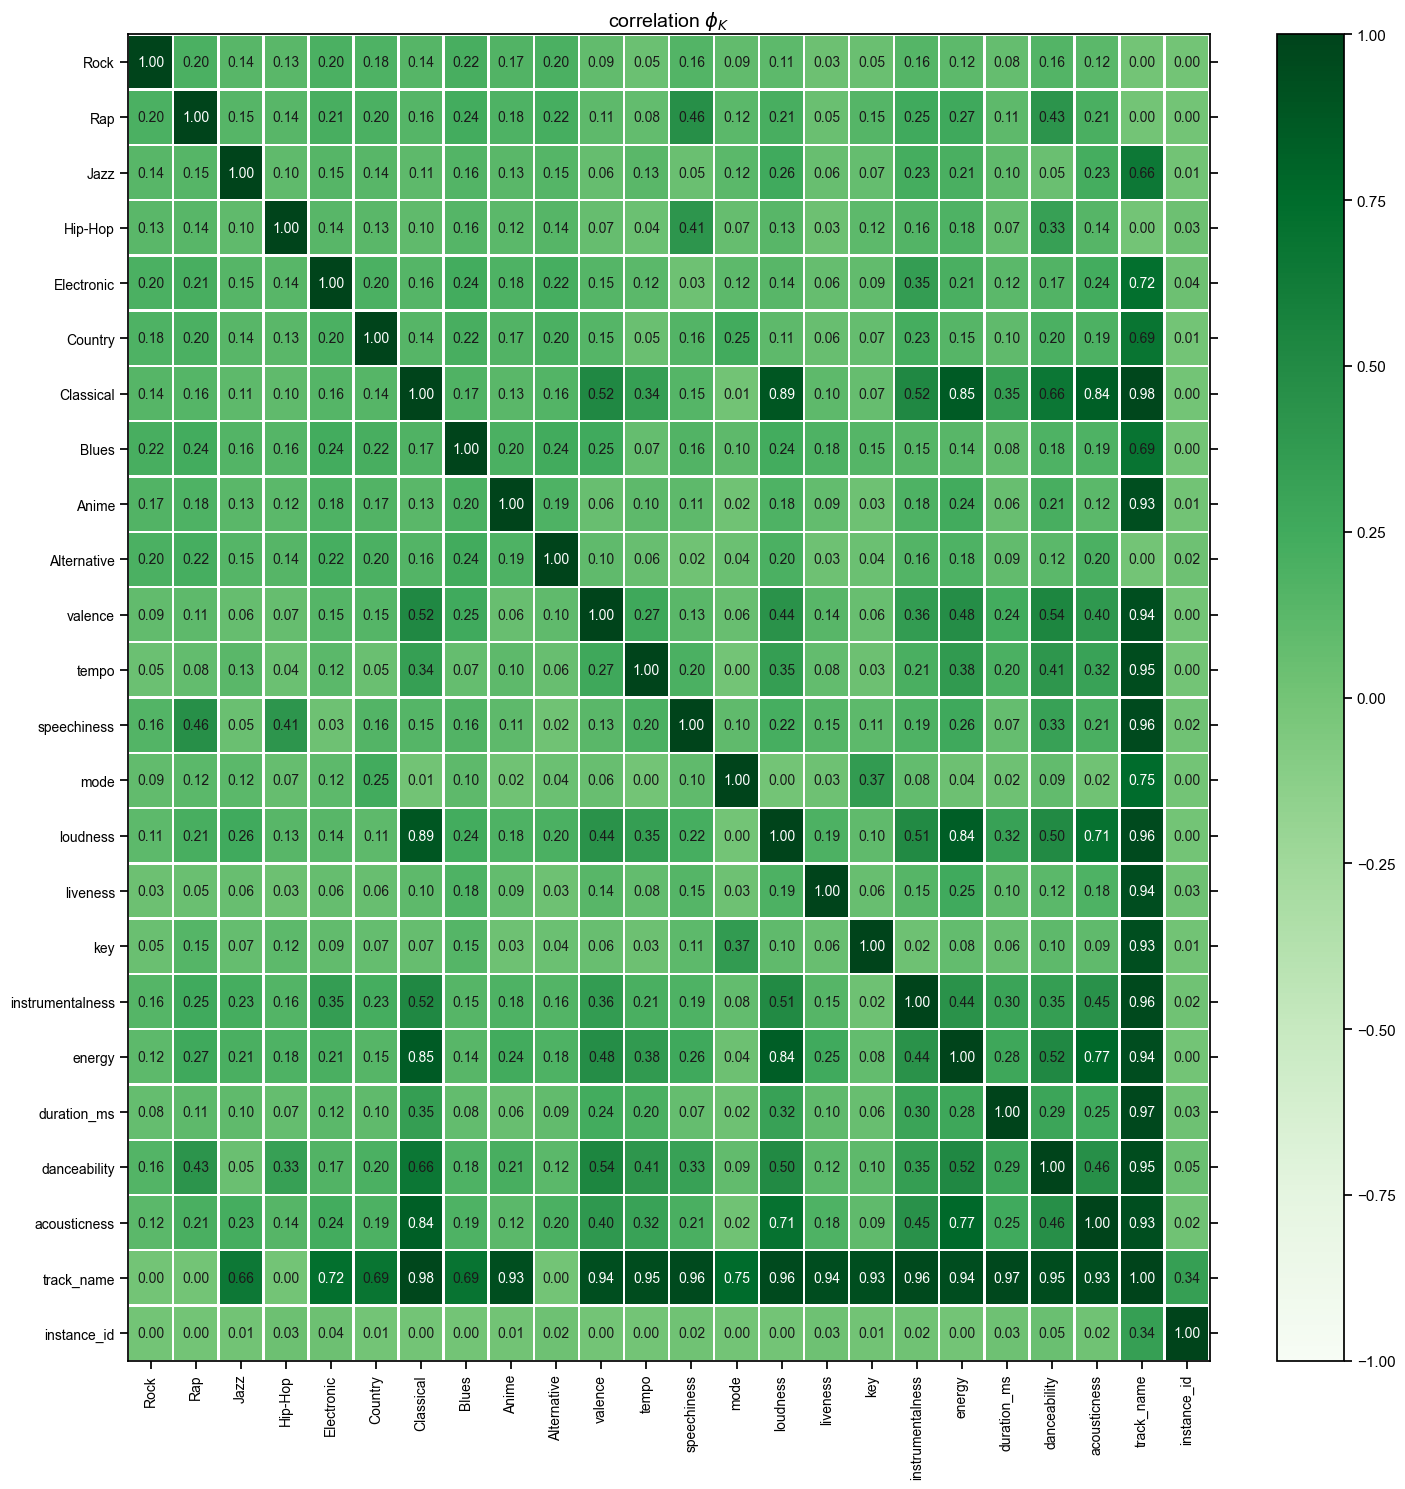

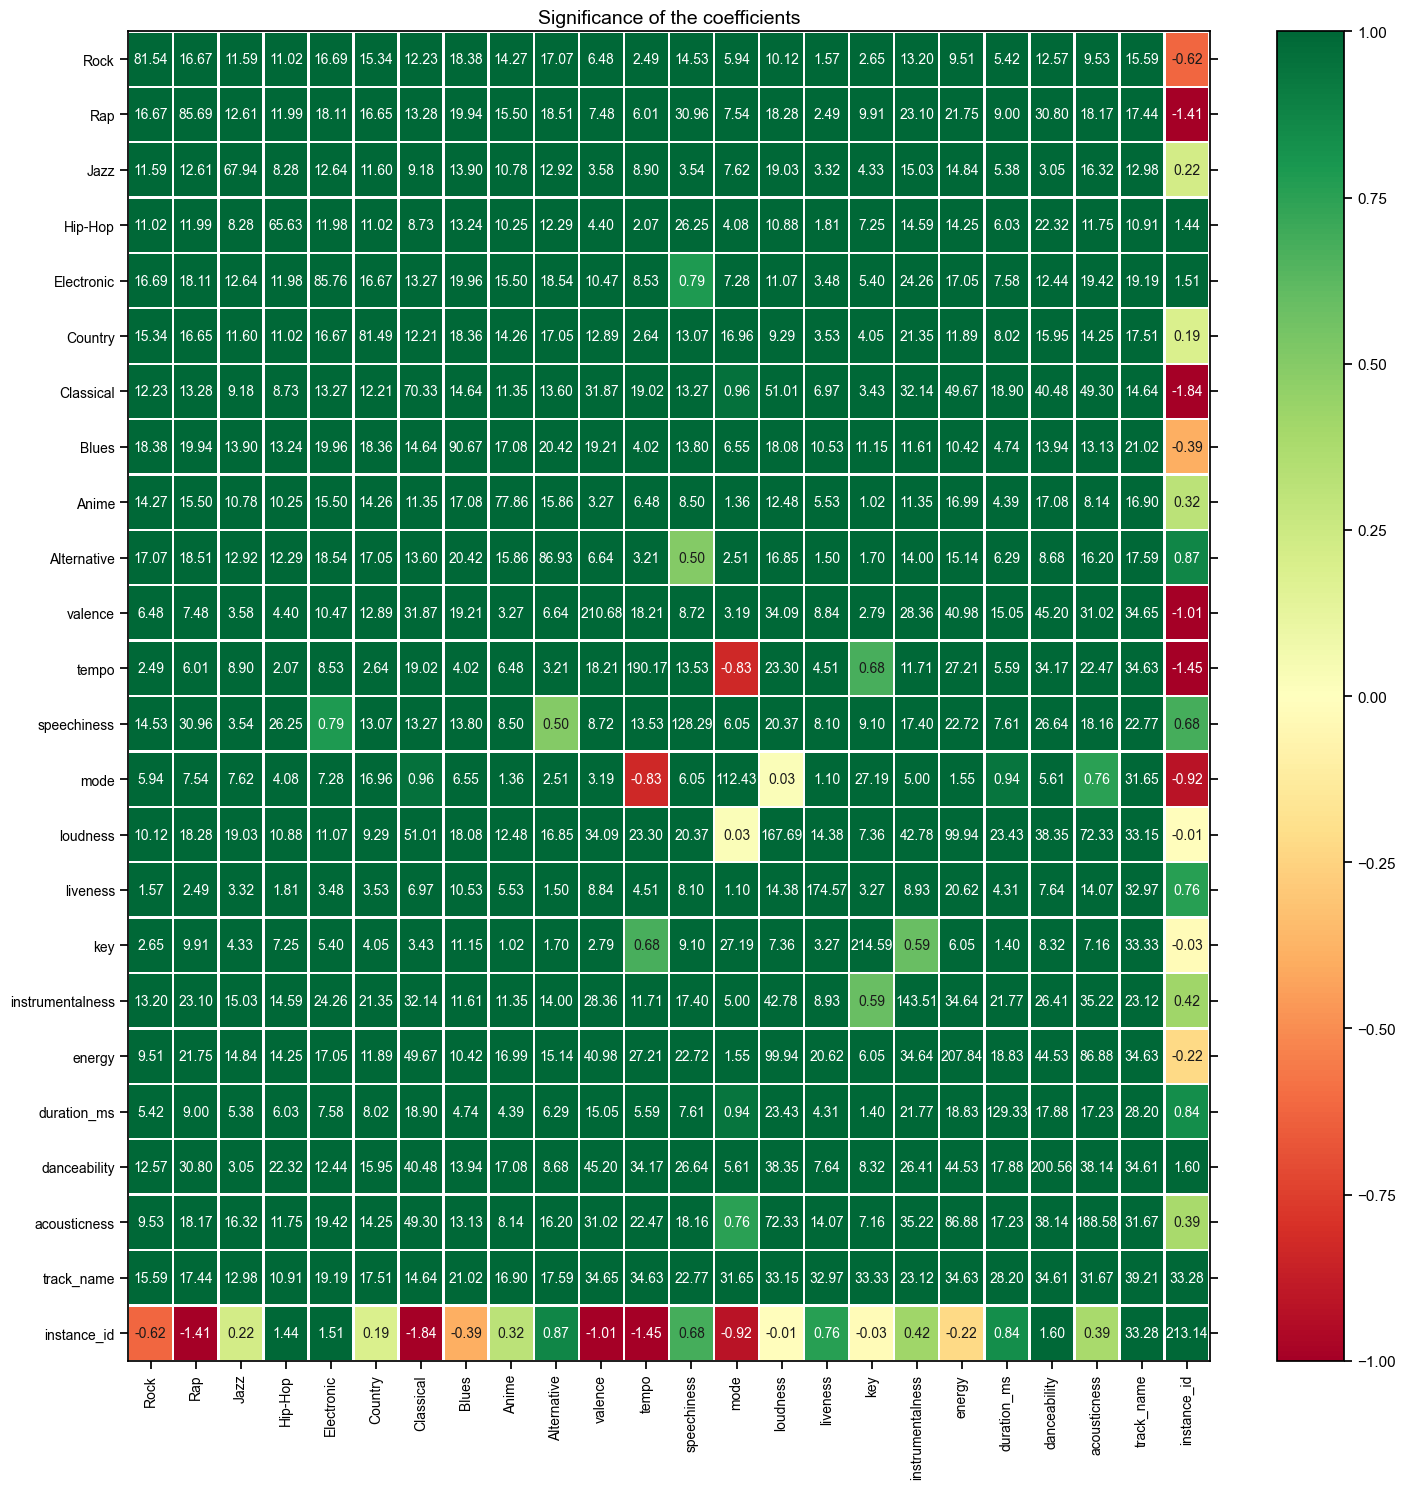

In [89]:
phik_help(a)

### Пропуски

Проверим данные на пропуски:

In [90]:
train_data.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               441
valence               0
music_genre           0
dtype: int64

Признаки key и mode являются категориальными признаками, поэтому поставить на них "заглушку" может быть хорошей идеей. А вот признак tempo может быть очень важной характеристикой жанра. Выберем хорошо коррелирующие признаки, сгрупируем по ним и возьмём среднее значение. 

In [91]:
#Пересечения NaN в двух стоолбцах
# train_data.loc[(train_data['mode'].isna()) & (train_data['key'].isna())].shape

(22, 15)

In [92]:
# for key in train_data['key'].unique():
#     if not pd.isnull(key):
#         popular = train_data[(train_data['key'] == key) & ~(train_data['mode'].isna())]['mode'].mode()[0]
#         train_data.loc[(train_data['key'] == key) & (train_data['mode'].isna()), 'mode'] = popular
#         test_data.loc[(test_data['key'] == key) & (test_data['mode'].isna()), 'mode'] = popular

In [93]:
# for mode in train_data['mode'].unique():
#     if not pd.isnull(mode):
#         popular = train_data[(train_data['mode'] == mode) & ~(train_data['key'].isna())]['key'].mode()[0]
#         train_data.loc[(train_data['mode'] == mode) & (train_data['key'].isna()), 'key'] = popular
#         test_data.loc[(test_data['mode'] == mode) & (test_data['key'].isna()), 'key'] = popular

In [95]:
# train_data['key'] = train_data['key'].fillna('unknown_key')
# train_data['modality'] = train_data['modality'].fillna('unknown_modality')

# test_data['key'] = test_data['key'].fillna('unknown_key')
# test_data['modality'] = test_data['modality'].fillna('unknown_modality')

Лучшими признаками по корреляции являются **danceability** и **energy**. В обоих признаках значения отнорированы и лежат в интервале [0, 1]. Категоризируем эти признаки и заполним пропуски медианой. 

In [ ]:
# bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
# labels = ['E_dance', 'D_dance', 'C_dance', 'B_dance', 'A_dance']
# train_data['danceability_category'] = pd.cut(train_data.danceability, bins=bins, labels=labels, right = True)
# test_data['danceability_category'] = pd.cut(test_data.danceability, bins=bins, labels=labels, right = True)

In [ ]:
# labels = ['E_energy', 'D_energy', 'C_energy', 'B_energy', 'A_energy']
# train_data['energy_category'] = pd.cut(train_data.energy, bins=bins, labels=labels, right = True)
# test_data['energy_category'] = pd.cut(test_data.energy, bins=bins, labels=labels, right = True)

In [ ]:
# train_data.groupby('danceability_category')['tempo'].agg(['mean', 'median', 'count'])

In [ ]:
# train_data.groupby('energy_category')['tempo'].agg(['mean', 'median', 'count'])

In [ ]:
# for dance_category in train_data['danceability_category'].unique():
#     for en_category in train_data['energy_category'].unique():
#         median = train_data[(train_data.danceability_category == dance_category) & \
#                             (train_data.energy_category == en_category)]['tempo'].median()
#         train_data.loc[((train_data.danceability_category == dance_category) & \
#                             (train_data.energy_category == en_category) & \
#                         (train_data.tempo.isna())), 'tempo'] = median
#         test_data.loc[((test_data.danceability_category == dance_category) & \
#                     (test_data.energy_category == en_category) & \
#                 (test_data.tempo.isna())), 'tempo'] = median

Проверим

In [ ]:
# train_data.isna().sum()

In [ ]:
# test_data.isna().sum()

### Реализация функций

Пропуски, аномальные значения есть как в тренировочном датасете, так и в тестовов. Поэтому необходим хороший метод для чистки данных. Для автоматизации всего процесса реализуем алгоритм преобработки данных при её загрузке

In [97]:
def upload_data():
    try:
        train = pd.read_csv("data/kaggle_music_genre_train.csv")
        test = pd.read_csv("data/kaggle_music_genre_test.csv")
        train = track_name_cleaner(train)
        test = track_name_cleaner(test)
        return train, test
    except:
        print("Не удалось загрузить данные!!!")
        return -1
    

def binningFeatures(df):
    speech_labels = ['OnlyMusic', 'OnlyMusic_Mix', 'Mix', 'Mix_Speech', 'Speech']
    speech_bins = [0, 0.2, 0.4, 0.60, 0.8, 1]
    df['speechiness_type'] = pd.cut(df['speechiness'], bins=speech_bins, labels=speech_labels, right=True, include_lowest=True)
    
    mood_labels = ['plak_plak', 'Sad', 'Normal', 'Happy', 'Get_High']
    mood_bins = [0, 0.2, 0.4, 0.60, 0.8, 1]
    df['mood'] = pd.cut(df['valence'], bins=mood_bins, labels=mood_labels, right=True, include_lowest=True)
    
    liveness_labels = ['very_boring', 'boring', 'Normal', 'popular' , 'very_popular']
    mood_bins = [0, 0.2, 0.4, 0.60, 0.8, 1]
    df['liveness_type'] = pd.cut(df['valence'], bins=mood_bins, labels=mood_labels, right=True, include_lowest=True)
    
    
    
    return df


def makeNewFeatures(df):
    df.rename(columns={'mode': 'modality'}, inplace=True)
    df = binningFeatures(df)
    
    df['instrumental'] = np.where(df['instrumentalness'] > 0.5, 1, 0)
    #df['live'] = np.where(df['liveness'] > 0.5, 1, 0)
    df['track_name_lenght'] = df['track_name'].apply(len)
    df['track_name_words'] = df['track_name'].str.split().str.len()
    
    df.drop(columns=['obtained_date'], inplace = True)
    return df



def clean_data(df):
    df.loc[df['duration_ms'] == -1, 'duration_ms'] = df[df['duration_ms'] > 0].median()
    low, high = df['duration_ms'].quantile([0.01, 0.99])
    mask = df[col].between(low, high)
    df = df[mask]
    return df

def null_input(train, test):
    
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
    labels = ['E_dance', 'D_dance', 'C_dance', 'B_dance', 'A_dance']
    train['danceability_category'] = pd.cut(train.danceability, bins=bins, labels=labels, right = True)
    test['danceability_category'] = pd.cut(test.danceability, bins=bins, labels=labels, right = True)
    
    labels = ['E_energy', 'D_energy', 'C_energy', 'B_energy', 'A_energy']
    train['energy_category'] = pd.cut(train.energy, bins=bins, labels=labels, right = True)
    test['energy_category'] = pd.cut(test.energy, bins=bins, labels=labels, right = True)
    
    for dance_category in train['danceability_category'].unique():
        for en_category in train['energy_category'].unique():
            median = train[(train.danceability_category == dance_category) & \
                                (train.energy_category == en_category)]['tempo'].median()
            train.loc[((train.danceability_category == dance_category) & \
                                (train.energy_category == en_category) & \
                            (train.tempo.isna())), 'tempo'] = median
            test.loc[((test.danceability_category == dance_category) & \
                        (test.energy_category == en_category) & \
                    (test.tempo.isna())), 'tempo'] = median
            
    for en_category in train['energy_category'].unique():
        median = train[train.energy_category == en_category]['loudness'].median()
        train.loc[(train.energy_category == en_category), 'loudness/energy'] = median
        test.loc[(test.energy_category == en_category), 'loudness/energy'] = median    
    
    
    for cat_liveness_type in train['liveness_type'].unique():
        median = train[train.liveness_type == cat_liveness_type]['loudness'].median()
        train.loc[(train.liveness_type == cat_liveness_type), 'loudness/liveness'] = median
        test.loc[(test.liveness_type == cat_liveness_type), 'loudness/liveness'] = median   
        
    for energy_type in train['energy_category'].unique():
        median = train[train['energy_category'] == energy_type]['danceability'].median()
        train.loc[(train['energy_category'] == energy_type), 'danceability/energy'] = median
        test.loc[(test['energy_category'] == energy_type), 'danceability/energy'] = median  
    
    global cat_features
    cat_features.append('energy_category')
    cat_features.append('danceability_category')
    cat_features.append('loudness/liveness')
    cat_features.append('loudness/energy')
    cat_features.append('danceability/energy')
    
    #Пропуски key и modality
    train['key'] = train['key'].fillna('unknown_key')
    train['modality'] = train['modality'].fillna('unknown_modality')

    test['key'] = test['key'].fillna('unknown_key')
    test['modality'] = test['modality'].fillna('unknown_modality')
    
    return train, test

num_features = []
cat_features = []
skewedFeatures = []

def update_columns_classes():
    global num_features, cat_features, skewedFeatures
    
    num_features = ['acousticness', 'danceability',
           'duration_ms', 'energy', 'instrumentalness', 'liveness',
           'loudness', 'speechiness', 'tempo', 'valence',
           'track_name_lenght', 'track_name_words', 'instrumental']

    cat_features = [ 'modality', 'key']

    skewedFeatures = ['duration_ms', 'speechiness', 'liveness', 'track_name_lenght', 'track_name_words',
     'instrumentalness', 'acousticness', 'loudness']


def add_kmean(train, test):

    kmean = KMeans(n_clusters=40, random_state=42)

    train_class = pd.DataFrame(kmean.fit_predict(train[num_features]), columns = ['kmean'])
    test_class = pd.DataFrame(kmean.predict(test[num_features]), columns = ['kmean'])

    train = train.join(train_class, how='outer')
    test = test.join(test_class, how='outer')
    
    train.columns = train.columns.astype(str)
    test.columns = test.columns.astype(str)
    
    num_features.append('kmean')
    return train, test

def add_birch(train, test):
    brc = Birch(n_clusters=40) 
    train_class = pd.DataFrame(brc.fit_predict(train[num_features]), columns = ['Birch'])
    test_class = pd.DataFrame(brc.predict(test[num_features]), columns = ['Birch'])

    train = train.join(train_class, how='outer')
    test = test.join(test_class, how='outer')

    train.columns = train.columns.astype(str)
    test.columns = test.columns.astype(str)
    num_features.append('Birch')
    return train, test

def get_good_data():
    train, test = upload_data()
    
    #Згружаем списки с названиями признаков
    update_columns_classes()
    
    #Новые признаки и разделяем на датасеты
    train = makeNewFeatures(train)
    test = makeNewFeatures(test)
    
    global cat_features
    cat_features.append('liveness_type')
    cat_features.append('speechiness_type')
    cat_features.append('mood')
    
    target = train['music_genre']
    train.drop(columns='music_genre', inplace = True)

    #Чистим промуски
    train, test = null_input(train, test)
    
    #train, test = TfV_TSVD_features(train, test, count=3)
    
    #train, test = TfV_TSVD_kmean(train, test, n_clust = 20)
    
    #train, test = add_kmean(train, test)
    #train, test = add_birch(train, test)
    
    #Добавляем ещё признаки связанные с названием
    #train, test = generate_count_vectot_features(train, test, count=5)
    train = detect_language(train)
    test = detect_language(test)

    #Кодируем признаки
    labelencoder = LabelEncoder()
    target = labelencoder.fit_transform(target)
    
    return train.drop(columns = 'instance_id'), pd.DataFrame(target), test, labelencoder

def use_upscaling(data, target):
    if type(target) == np.ndarray:
        target = pd.DataFrame(target)
        
    smote = SMOTE(random_state=42, k_neighbors=20)
    data_SMOTE, train_SMOTE = smote.fit_resample(data.values, target.values)  

    data = pd.concat([data, pd.DataFrame(data_SMOTE, columns = data.columns)])
    target = pd.concat([target, pd.DataFrame(train_SMOTE, columns = target.columns)])

    data.reset_index(drop=True, inplace=True)
    target.reset_index(drop=True, inplace=True)  

    return data, target

In [115]:
#Загружем данные и создаем доп признаки
train, target, test, labelencoder = get_good_data()

In [116]:
#Кодировщики
le = LabelEncoder()
looe = LeaveOneOutEncoder()
pt = PowerTransformer(copy=False)
rs = RobustScaler()

In [117]:
for col in cat_features:
    train[col]  = le.fit_transform(train[col])
    test[col]  = le.transform(test[col])
    
target = le.fit_transform(target)

train['track_name_looe']= looe.fit_transform(train['track_name'], target)
test['track_name_looe']= looe.transform(test['track_name'])

In [118]:
train[skewedFeatures] = pt.fit_transform(train[skewedFeatures])
test[skewedFeatures] = pt.transform(test[skewedFeatures])

In [119]:
train[skewedFeatures] = rs.fit_transform(train[skewedFeatures])
test[skewedFeatures] = rs.transform(test[skewedFeatures])

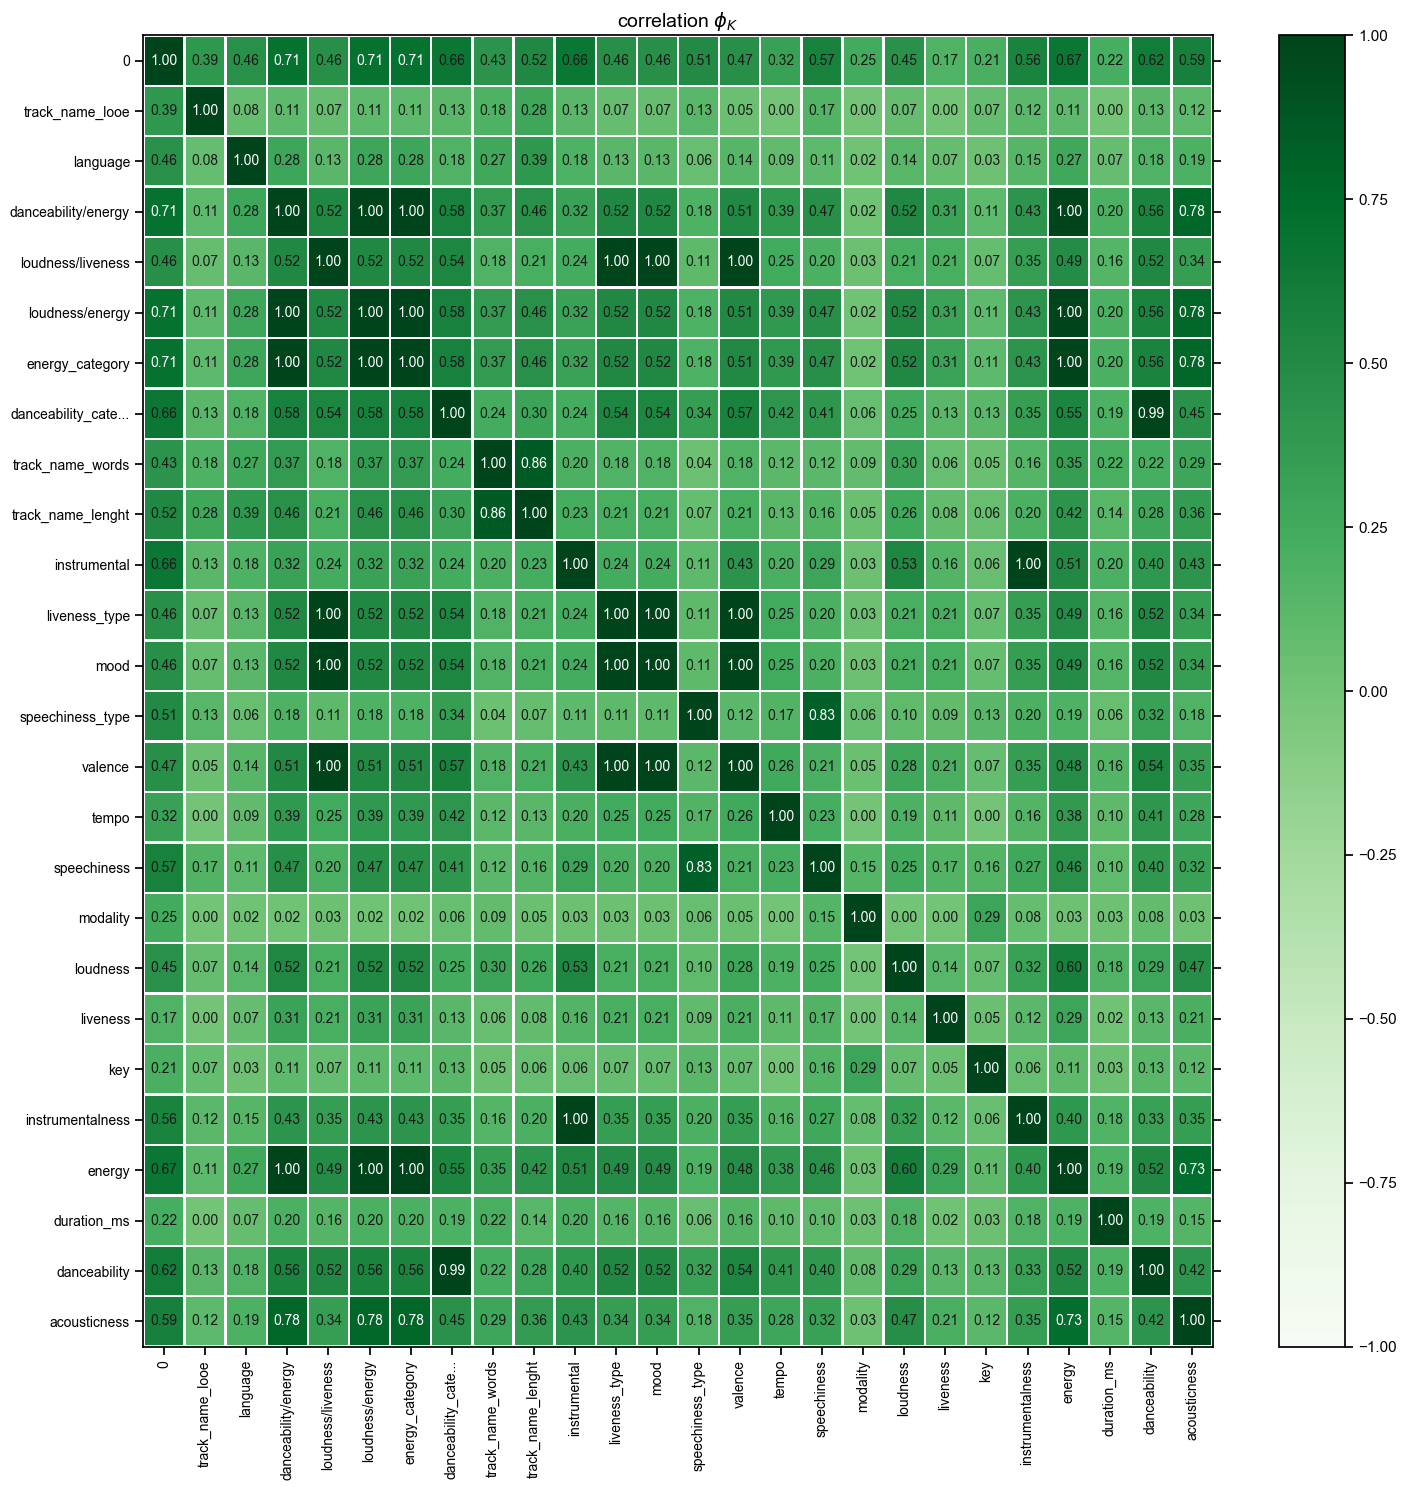

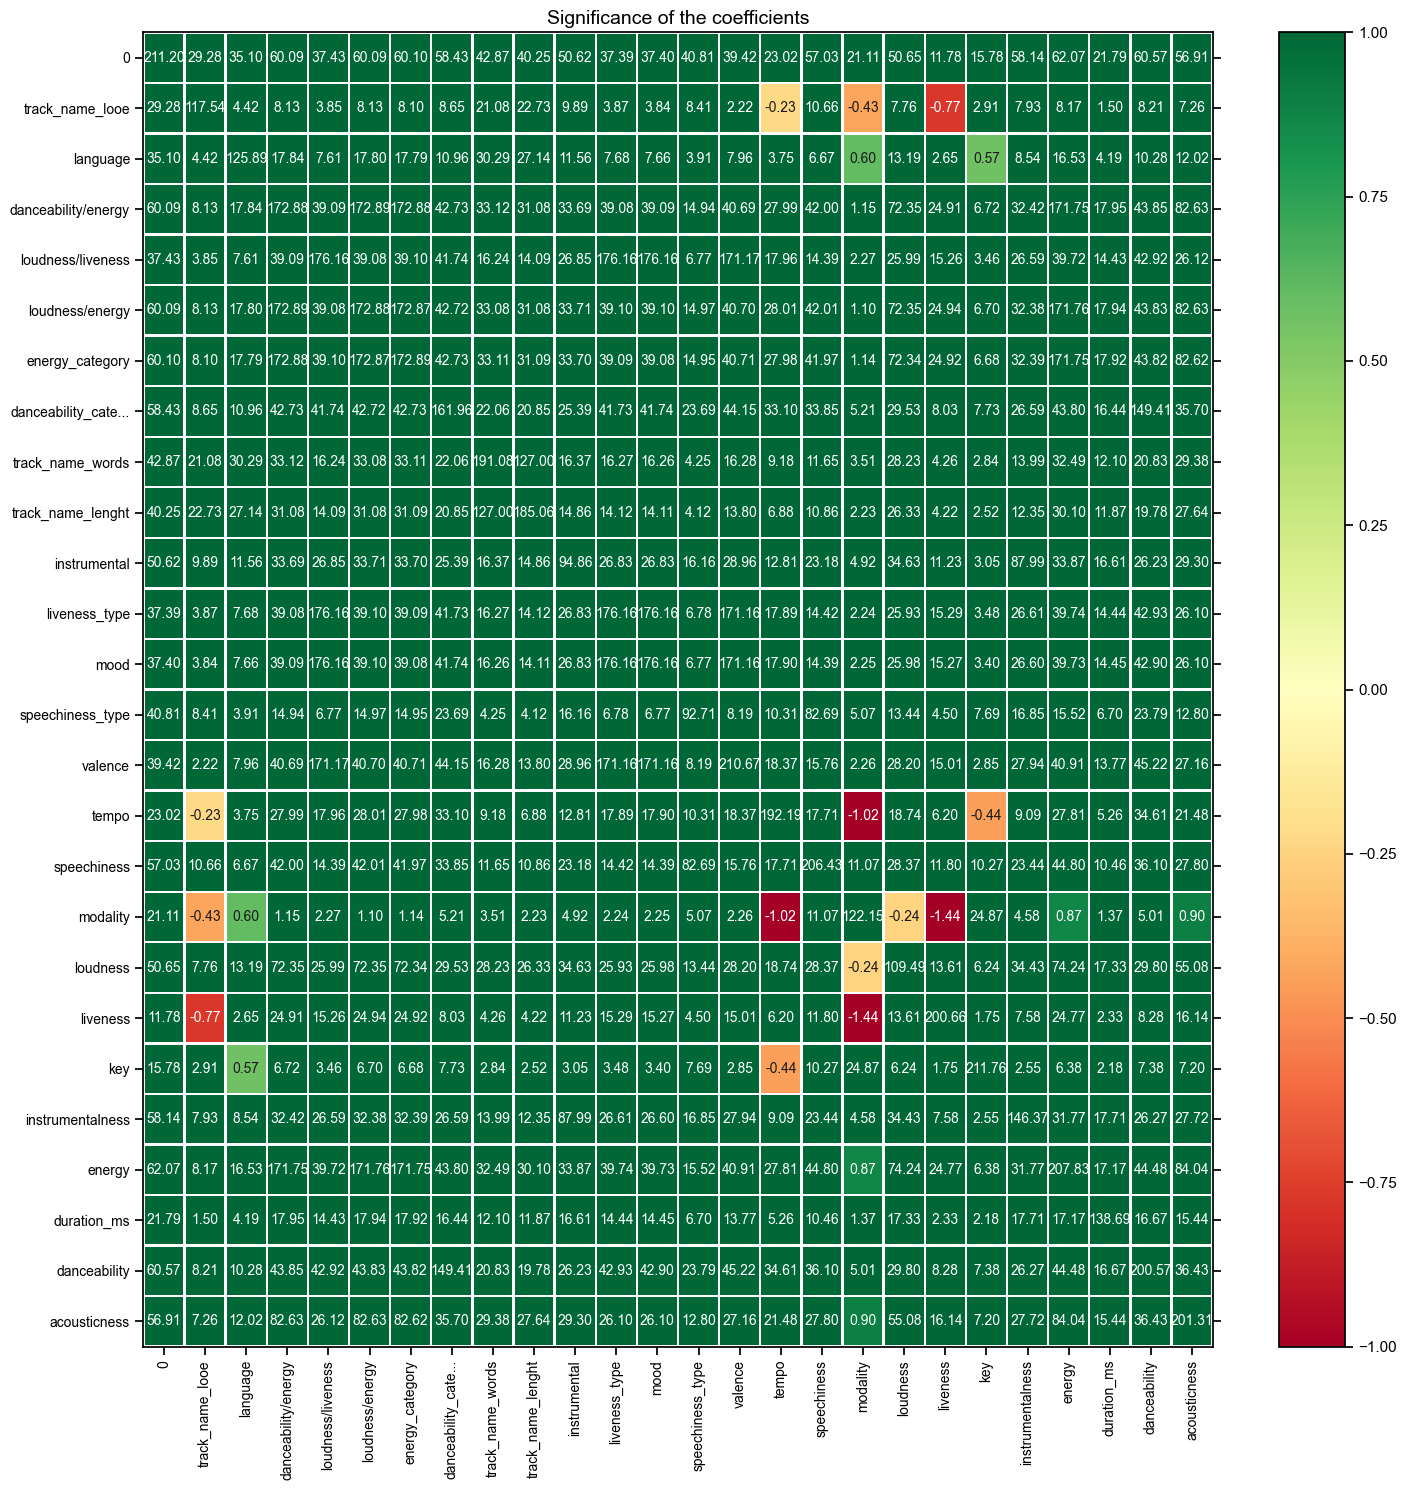

In [104]:
phik_help(pd.concat([train[:10000], pd.DataFrame(target[:10000])], axis=1))

# Построение модели

Для экономии напишем функцию, которая будет выводить основную онформцию об обученной моделе

In [105]:
def make_classification_plots(model_preds, y_test, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    cm_matrix = confusion_matrix(y_test, model_preds)

    # 1 - Summary Statistics
    accuracy = accuracy_score(y_test, model_preds) # % positive out of all predicted positives
    balanced_accuracy = balanced_accuracy_score(y_test, model_preds)
    precision = precision_score(y_test, model_preds, average='weighted') # % positive out of all predicted positives
    recall =  recall_score(y_test, model_preds, average='weighted') # % positive out of all supposed to be positives
    f1 = f1_score(y_test, model_preds, average='weighted')
    fbeta = fbeta_score(y_test, model_preds, beta = 0.5, average = 'weighted')
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Balanced Accuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | F1-Score = {:.2%} | fbeta = {:.2%}'.format(accuracy, balanced_accuracy , precision, recall, f1, fbeta)
    print(stats_summary)

    # 2 : Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, model_preds, ax=axes[0])
    axes[0].set_title("Confusion Matrix")

    # 3 : Normalized Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, model_preds, ax=axes[1], normalize="true", values_format=".0%")
    axes[1].set_title("Normalized Confusion Matrix")

    fig.suptitle(f"{title} Test Metrics", fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # 4 : Classification Report
    class_report = classification_report(y_test, model_preds)
    print('\n', f"{title} Classification Report: \n {class_report}")

    plt.style.use('ggplot')

## CatBoostClassifier

Для начала попробуем построить обучную многоклассовую модель

### Многоклассавая

In [106]:
X_train, X_test, y_train, y_test = train_test_split(train, target, 
                                                    test_size=0.2, random_state=42, shuffle=True)

In [107]:
train_pool = Pool(X_train, y_train) # cat_features=[0,2,5])
test_pool = Pool(X_test)

In [108]:
params = {
        'auto_class_weights': 'Balanced',
        'boosting_type': 'Ordered',
        'max_depth': 6,
        'n_estimators':3000,
        'learning_rate': 0.01,
        'thread_count': -1,
        'l2_leaf_reg': 3.0,
        'random_state': 42,
        'classes_count': 10,
        'verbose': 100,
        'custom_metric': ['AUC', 'Accuracy'],
        'eval_metric' : 'TotalF1:average=Micro',
        'use_best_model': True
    }
    
clf = CatBoostClassifier(**params)
clf.fit(train_pool, eval_set=(X_test,  y_test), plot=True)#, eval_set=(X_test,  y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3203761	test: 0.3240142	best: 0.3240142 (0)	total: 277ms	remaining: 13m 50s
100:	learn: 0.4344889	test: 0.4328973	best: 0.4338084 (99)	total: 11.9s	remaining: 5m 40s
200:	learn: 0.4598096	test: 0.4500891	best: 0.4504918 (196)	total: 23.4s	remaining: 5m 26s
300:	learn: 0.4790458	test: 0.4557855	best: 0.4568550 (295)	total: 35s	remaining: 5m 14s
400:	learn: 0.4951713	test: 0.4647453	best: 0.4657031 (399)	total: 46.5s	remaining: 5m 1s
500:	learn: 0.5072427	test: 0.4753386	best: 0.4766286 (494)	total: 57.7s	remaining: 4m 47s
600:	learn: 0.5157604	test: 0.4839288	best: 0.4839288 (600)	total: 1m 9s	remaining: 4m 36s
700:	learn: 0.5219450	test: 0.4870631	best: 0.4883170 (657)	total: 1m 20s	remaining: 4m 24s
800:	learn: 0.5272253	test: 0.4903062	best: 0.4915861 (793)	total: 1m 31s	remaining: 4m 12s
900:	learn: 0.5312518	test: 0.4934819	best: 0.4934819 (900)	total: 1m 43s	remaining: 4m
1000:	learn: 0.5362578	test: 0.4967761	best: 0.4967761 (1000)	total: 1m 54s	remaining: 3m 49s
1100

Text(0.5, 1.0, 'CatBoost Feature Importance')

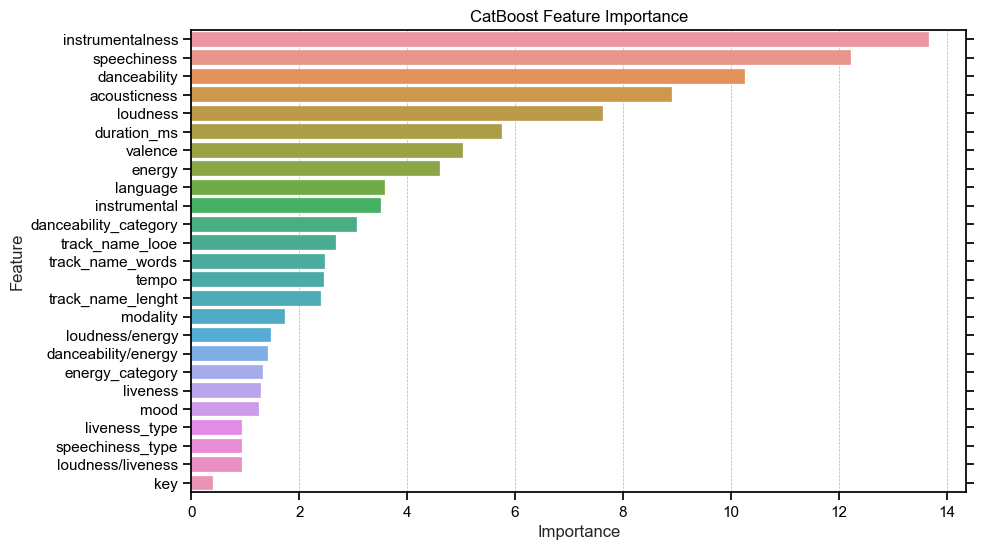

In [109]:
results = list(zip(X_train, clf.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
se.barplot(x = importance.Importance, y = importance.Feature)
plt.title("CatBoost Feature Importance")

[Summary Statistics]
Accuracy = 50.21% | Balanced Accuracy = 52.06% | Precision = 49.82% | Recall = 50.21% | F1-Score = 49.52% | fbeta = 49.57%


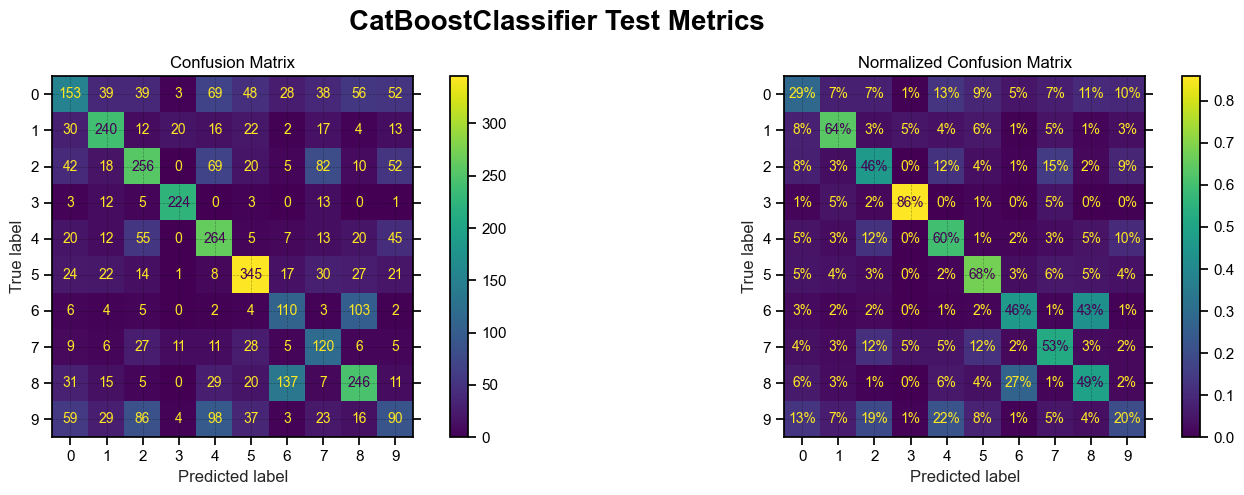


 CatBoostClassifier Classification Report: 
               precision    recall  f1-score   support

           0       0.41      0.29      0.34       525
           1       0.60      0.64      0.62       376
           2       0.51      0.46      0.48       554
           3       0.85      0.86      0.85       261
           4       0.47      0.60      0.52       441
           5       0.65      0.68      0.66       509
           6       0.35      0.46      0.40       239
           7       0.35      0.53      0.42       228
           8       0.50      0.49      0.50       501
           9       0.31      0.20      0.24       445

    accuracy                           0.50      4079
   macro avg       0.50      0.52      0.50      4079
weighted avg       0.50      0.50      0.50      4079



In [110]:
make_classification_plots(clf.predict(X_test), y_test, 'CatBoostClassifier')

### Ансамбль, один против всех

In [120]:
target_str = labelencoder.inverse_transform(target)
target_ohe = pd.get_dummies(target_str)

Так как у нас двуэтапная модель, то данные сперва разбиваются на 2 части. 

In [121]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(train, target_ohe, 
                                                    test_size=0.5, random_state=42, shuffle=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7279328	test: 0.7199143	best: 0.7199143 (0)	total: 25ms	remaining: 1m 27s
200:	learn: 0.8820377	test: 0.8834184	best: 0.8840082 (187)	total: 4.17s	remaining: 1m 8s
400:	learn: 0.8976729	test: 0.8929381	best: 0.8941042 (383)	total: 8.43s	remaining: 1m 5s
600:	learn: 0.9056480	test: 0.8963143	best: 0.8963143 (599)	total: 12.5s	remaining: 1m
800:	learn: 0.9111840	test: 0.8963143	best: 0.8974822 (688)	total: 16.5s	remaining: 55.7s
1000:	learn: 0.9165921	test: 0.8956797	best: 0.8974822 (688)	total: 20.6s	remaining: 51.5s
1200:	learn: 0.9223263	test: 0.8985360	best: 0.8991210 (1136)	total: 25s	remaining: 47.8s
1400:	learn: 0.9252866	test: 0.9008750	best: 0.9008750 (1360)	total: 29s	remaining: 43.5s
1600:	learn: 0.9261666	test: 0.8997224	best: 0.9014432 (1459)	total: 32.5s	remaining: 38.5s
1800:	learn: 0.9272395	test: 0.9002739	best: 0.9014432 (1459)	total: 35.4s	remaining: 33.4s
2000:	learn: 0.9283765	test: 0.9002739	best: 0.9014432 (1459)	total: 38.4s	remaining: 28.8s
2200:	lear

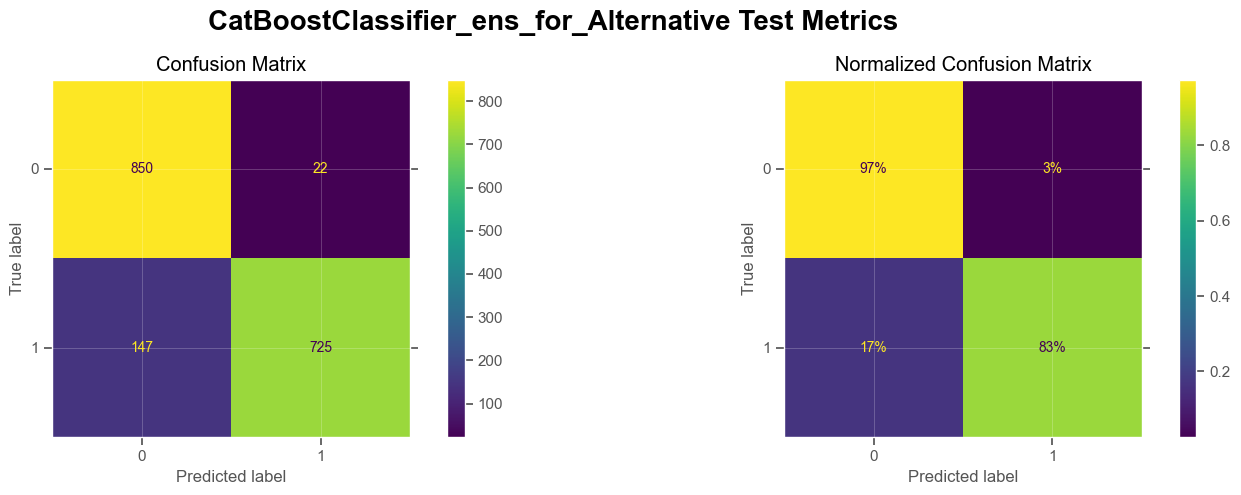


 CatBoostClassifier_ens_for_Alternative Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.97      0.91       872
           1       0.97      0.83      0.90       872

    accuracy                           0.90      1744
   macro avg       0.91      0.90      0.90      1744
weighted avg       0.91      0.90      0.90      1744



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7572417	test: 0.8281011	best: 0.8281011 (0)	total: 19.4ms	remaining: 1m 7s
200:	learn: 0.9147117	test: 0.9218095	best: 0.9218095 (198)	total: 3.81s	remaining: 1m 2s
400:	learn: 0.9382772	test: 0.9484579	best: 0.9484579 (397)	total: 7.6s	remaining: 58.7s
600:	learn: 0.9497046	test: 0.9558979	best: 0.9558979 (541)	total: 11.4s	remaining: 55.2s
800:	learn: 0.9571639	test: 0.9580231	best: 0.9585543 (762)	total: 15.4s	remaining: 51.8s
1000:	learn: 0.9620978	test: 0.9622724	best: 0.9622724 (974)	total: 19.2s	remaining: 47.8s
1200:	learn: 0.9660090	test: 0.9633339	best: 0.9638656 (1094)	total: 22.9s	remaining: 43.8s
1400:	learn: 0.9689576	test: 0.9622695	best: 0.9638656 (1094)	total: 26.9s	remaining: 40.3s
1600:	learn: 0.9708828	test: 0.9628004	best: 0.9638656 (1094)	total: 30.6s	remaining: 36.3s
1800:	learn: 0.9727480	test: 0.9622703	best: 0.9638656 (1094)	total: 34.2s	remaining: 32.3s
2000:	learn: 0.9731093	test: 0.9633331	best: 0.9638656 (1094)	total: 37.4s	remaining: 28s
2200:

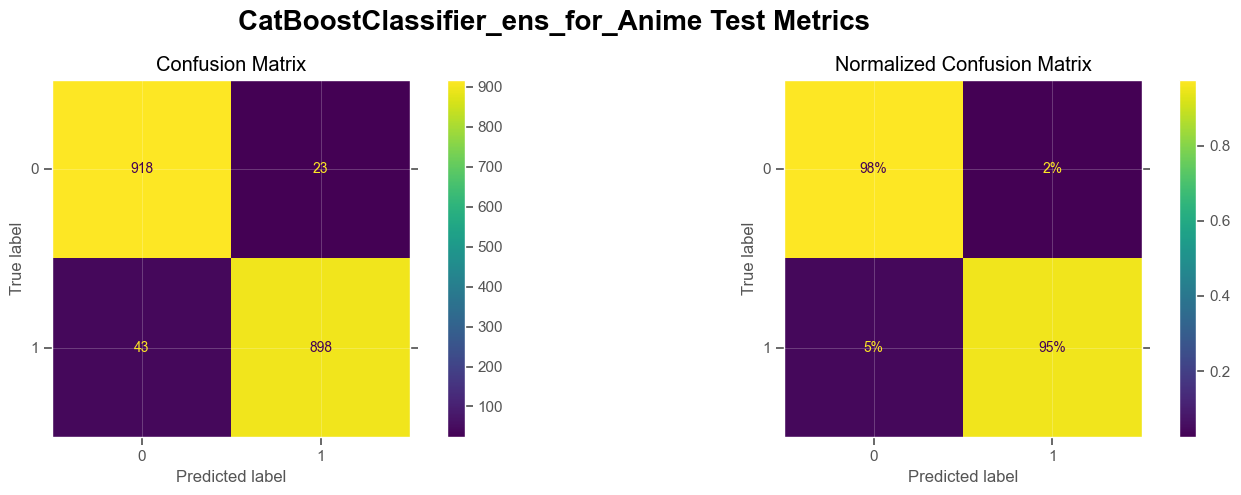


 CatBoostClassifier_ens_for_Anime Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       941
           1       0.98      0.95      0.96       941

    accuracy                           0.96      1882
   macro avg       0.97      0.96      0.96      1882
weighted avg       0.97      0.96      0.96      1882



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7938683	test: 0.7886569	best: 0.7886569 (0)	total: 19.5ms	remaining: 1m 8s
200:	learn: 0.8859155	test: 0.8889436	best: 0.8889436 (199)	total: 3.74s	remaining: 1m 1s
400:	learn: 0.9066035	test: 0.9041683	best: 0.9041683 (392)	total: 7.46s	remaining: 57.6s
600:	learn: 0.9136949	test: 0.9052890	best: 0.9058538 (451)	total: 11.2s	remaining: 54.2s
800:	learn: 0.9178081	test: 0.9063918	best: 0.9069650 (695)	total: 14.9s	remaining: 50.2s
1000:	learn: 0.9217347	test: 0.9080728	best: 0.9086390 (849)	total: 18.6s	remaining: 46.3s
1200:	learn: 0.9272483	test: 0.9108758	best: 0.9114373 (1192)	total: 22.3s	remaining: 42.7s
1400:	learn: 0.9304168	test: 0.9102979	best: 0.9114373 (1192)	total: 26.3s	remaining: 39.4s
1600:	learn: 0.9337778	test: 0.9114425	best: 0.9120040 (1543)	total: 30.1s	remaining: 35.7s
1800:	learn: 0.9373312	test: 0.9108705	best: 0.9131269 (1630)	total: 33.8s	remaining: 31.9s
2000:	learn: 0.9398055	test: 0.9097423	best: 0.9131269 (1630)	total: 37.6s	remaining: 28.2s
22

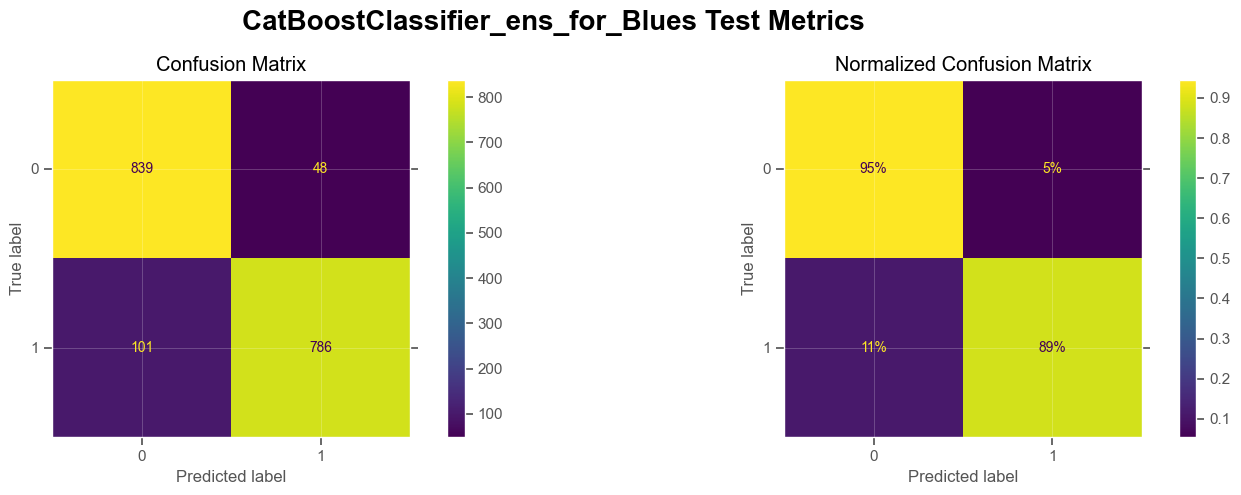


 CatBoostClassifier_ens_for_Blues Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       887
           1       0.94      0.89      0.91       887

    accuracy                           0.92      1774
   macro avg       0.92      0.92      0.92      1774
weighted avg       0.92      0.92      0.92      1774



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9533147	test: 0.9585480	best: 0.9585480 (0)	total: 18.8ms	remaining: 1m 5s
200:	learn: 0.9790838	test: 0.9744951	best: 0.9744951 (184)	total: 3.71s	remaining: 1m
400:	learn: 0.9845758	test: 0.9787458	best: 0.9787458 (360)	total: 7.43s	remaining: 57.4s
600:	learn: 0.9871465	test: 0.9798086	best: 0.9798086 (567)	total: 11.1s	remaining: 53.4s
800:	learn: 0.9883150	test: 0.9808713	best: 0.9808714 (716)	total: 14.8s	remaining: 49.9s
1000:	learn: 0.9893082	test: 0.9819340	best: 0.9819340 (991)	total: 18.4s	remaining: 45.9s
1200:	learn: 0.9901846	test: 0.9824653	best: 0.9824653 (1063)	total: 22s	remaining: 42.1s
1400:	learn: 0.9907689	test: 0.9824653	best: 0.9824653 (1063)	total: 25.7s	remaining: 38.5s
1600:	learn: 0.9910610	test: 0.9819339	best: 0.9824653 (1063)	total: 29.1s	remaining: 34.5s
1800:	learn: 0.9914115	test: 0.9829966	best: 0.9829966 (1730)	total: 32.7s	remaining: 30.8s
2000:	learn: 0.9921126	test: 0.9835280	best: 0.9835280 (1959)	total: 36.4s	remaining: 27.3s
2200:	l

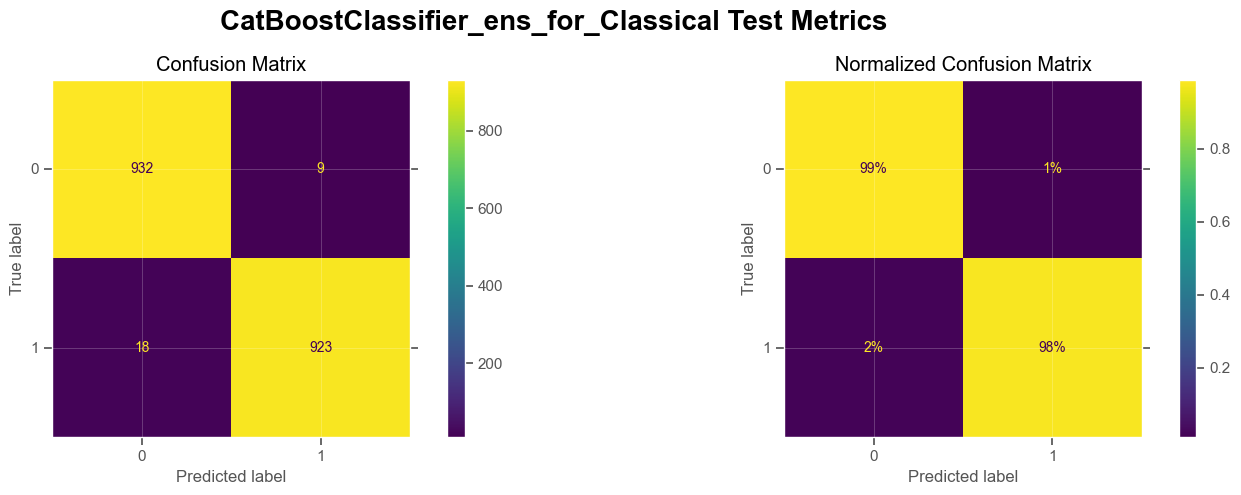


 CatBoostClassifier_ens_for_Classical Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       941
           1       0.99      0.98      0.99       941

    accuracy                           0.99      1882
   macro avg       0.99      0.99      0.99      1882
weighted avg       0.99      0.99      0.99      1882



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8297577	test: 0.8344590	best: 0.8344590 (0)	total: 17.6ms	remaining: 1m 1s
200:	learn: 0.9026378	test: 0.9182810	best: 0.9188146 (189)	total: 3.52s	remaining: 57.7s
400:	learn: 0.9265434	test: 0.9366742	best: 0.9366742 (387)	total: 7.15s	remaining: 55.3s
600:	learn: 0.9354797	test: 0.9399124	best: 0.9404468 (563)	total: 10.7s	remaining: 51.7s
800:	learn: 0.9419152	test: 0.9425964	best: 0.9442059 (727)	total: 14.2s	remaining: 47.8s
1000:	learn: 0.9456172	test: 0.9447412	best: 0.9452780 (967)	total: 17.7s	remaining: 44.1s
1200:	learn: 0.9496837	test: 0.9490290	best: 0.9490290 (1185)	total: 21.2s	remaining: 40.5s
1400:	learn: 0.9540564	test: 0.9479520	best: 0.9495638 (1300)	total: 24.8s	remaining: 37.1s
1600:	learn: 0.9562446	test: 0.9500983	best: 0.9506356 (1499)	total: 28.3s	remaining: 33.6s
1800:	learn: 0.9575203	test: 0.9474130	best: 0.9506356 (1499)	total: 31.8s	remaining: 30s
2000:	learn: 0.9583110	test: 0.9490220	best: 0.9506356 (1499)	total: 35s	remaining: 26.2s
2200:	

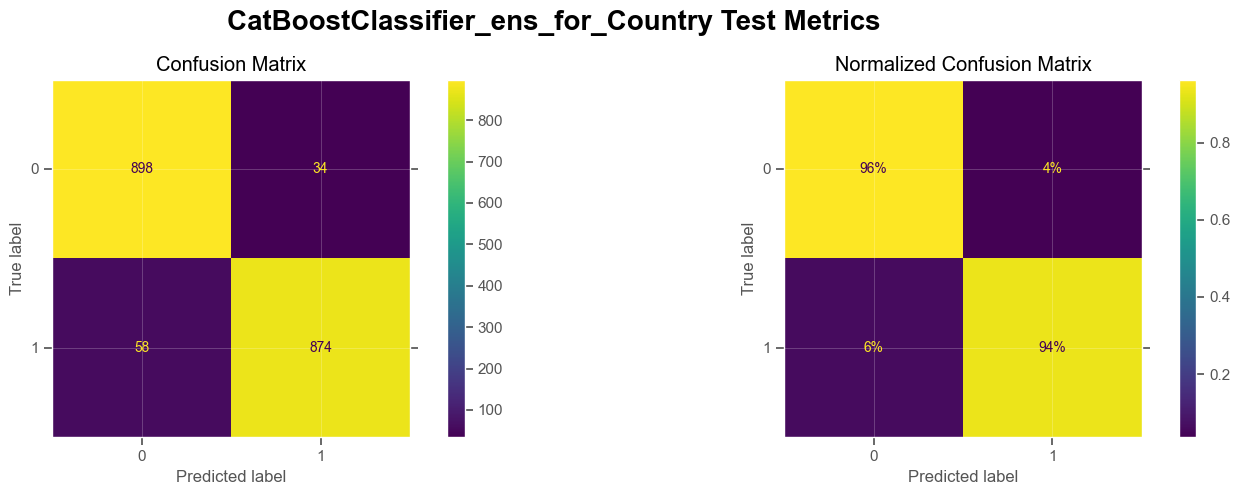


 CatBoostClassifier_ens_for_Country Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       932
           1       0.96      0.94      0.95       932

    accuracy                           0.95      1864
   macro avg       0.95      0.95      0.95      1864
weighted avg       0.95      0.95      0.95      1864



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8564049	test: 0.8383652	best: 0.8383652 (0)	total: 18.4ms	remaining: 1m 4s
200:	learn: 0.9126248	test: 0.9028098	best: 0.9028098 (200)	total: 3.6s	remaining: 59.2s
400:	learn: 0.9327077	test: 0.9209023	best: 0.9214683 (382)	total: 7.22s	remaining: 55.8s
600:	learn: 0.9402257	test: 0.9282385	best: 0.9282385 (587)	total: 11s	remaining: 52.9s
800:	learn: 0.9449465	test: 0.9293644	best: 0.9293644 (778)	total: 14.5s	remaining: 49s
1000:	learn: 0.9495426	test: 0.9304898	best: 0.9304923 (884)	total: 18.2s	remaining: 45.3s
1200:	learn: 0.9537033	test: 0.9333115	best: 0.9333115 (1085)	total: 21.8s	remaining: 41.8s
1400:	learn: 0.9564988	test: 0.9350057	best: 0.9350057 (1316)	total: 25.3s	remaining: 37.9s
1600:	learn: 0.9576794	test: 0.9361386	best: 0.9367025 (1521)	total: 29s	remaining: 34.4s
1800:	learn: 0.9591088	test: 0.9355722	best: 0.9372689 (1674)	total: 32.6s	remaining: 30.7s
2000:	learn: 0.9605380	test: 0.9372689	best: 0.9372689 (1674)	total: 35.7s	remaining: 26.8s
2200:	lea

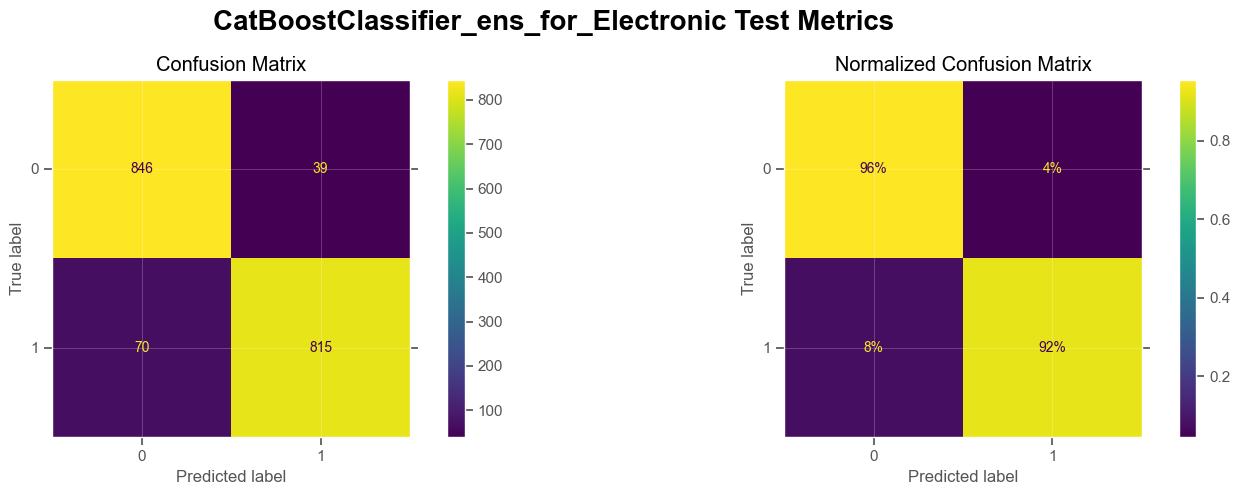


 CatBoostClassifier_ens_for_Electronic Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       885
           1       0.95      0.92      0.94       885

    accuracy                           0.94      1770
   macro avg       0.94      0.94      0.94      1770
weighted avg       0.94      0.94      0.94      1770



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8560534	test: 0.8678961	best: 0.8678961 (0)	total: 18.1ms	remaining: 1m 3s
200:	learn: 0.9248637	test: 0.9374498	best: 0.9379639 (195)	total: 3.57s	remaining: 58.6s
400:	learn: 0.9457542	test: 0.9576703	best: 0.9576703 (399)	total: 7.15s	remaining: 55.3s
600:	learn: 0.9571126	test: 0.9597480	best: 0.9597480 (586)	total: 10.8s	remaining: 52s
800:	learn: 0.9642313	test: 0.9623318	best: 0.9628477 (777)	total: 14.2s	remaining: 47.9s
1000:	learn: 0.9683395	test: 0.9643963	best: 0.9643963 (997)	total: 17.6s	remaining: 44s
1200:	learn: 0.9714059	test: 0.9680077	best: 0.9680079 (1170)	total: 21s	remaining: 40.1s
1400:	learn: 0.9731997	test: 0.9680074	best: 0.9680079 (1170)	total: 24.1s	remaining: 36s
1600:	learn: 0.9747621	test: 0.9695553	best: 0.9695553 (1454)	total: 27s	remaining: 32s
1800:	learn: 0.9761511	test: 0.9695553	best: 0.9700711 (1673)	total: 29.9s	remaining: 28.2s
2000:	learn: 0.9775401	test: 0.9705869	best: 0.9705869 (1831)	total: 32.7s	remaining: 24.5s
2200:	learn: 0

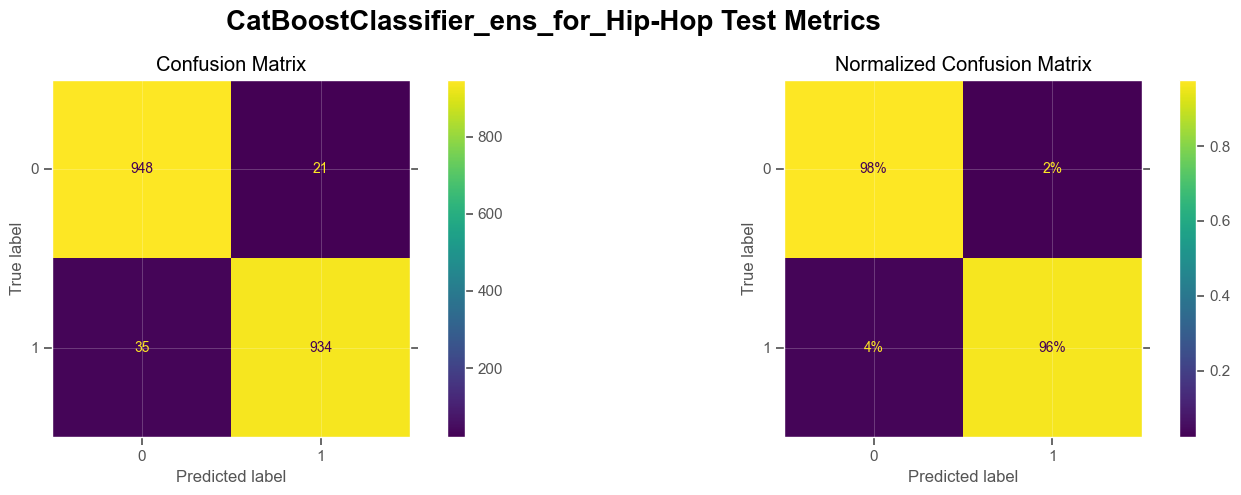


 CatBoostClassifier_ens_for_Hip-Hop Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       969
           1       0.98      0.96      0.97       969

    accuracy                           0.97      1938
   macro avg       0.97      0.97      0.97      1938
weighted avg       0.97      0.97      0.97      1938



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184052	test: 0.8520026	best: 0.8520026 (0)	total: 19.6ms	remaining: 1m 8s
200:	learn: 0.9231524	test: 0.9330751	best: 0.9330751 (196)	total: 3.57s	remaining: 58.6s
400:	learn: 0.9450111	test: 0.9554387	best: 0.9554387 (400)	total: 7.26s	remaining: 56.1s
600:	learn: 0.9555913	test: 0.9580302	best: 0.9585488 (584)	total: 10.8s	remaining: 52.3s
800:	learn: 0.9631456	test: 0.9595812	best: 0.9606202 (672)	total: 14.4s	remaining: 48.5s
1000:	learn: 0.9677357	test: 0.9611311	best: 0.9611311 (993)	total: 18s	remaining: 44.8s
1200:	learn: 0.9711643	test: 0.9626864	best: 0.9626864 (1182)	total: 21.6s	remaining: 41.4s
1400:	learn: 0.9732566	test: 0.9647572	best: 0.9652748 (1397)	total: 25.2s	remaining: 37.8s
1600:	learn: 0.9744194	test: 0.9637179	best: 0.9652748 (1397)	total: 28.7s	remaining: 34.1s
1800:	learn: 0.9748266	test: 0.9647532	best: 0.9652748 (1397)	total: 30.9s	remaining: 29.2s
2000:	learn: 0.9753498	test: 0.9652722	best: 0.9652748 (1397)	total: 33.4s	remaining: 25s
2200:	

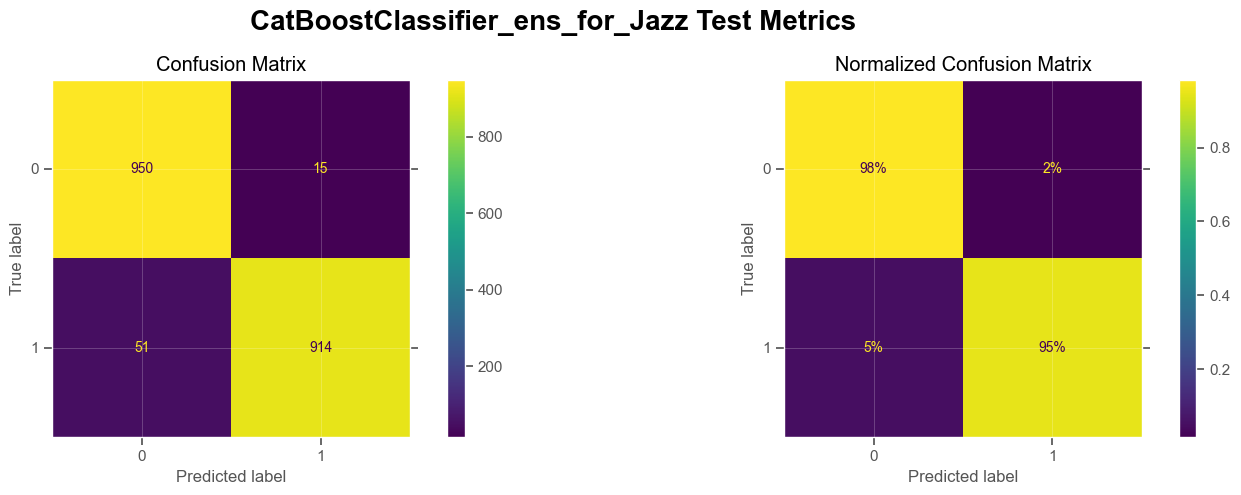


 CatBoostClassifier_ens_for_Jazz Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       965
           1       0.98      0.95      0.97       965

    accuracy                           0.97      1930
   macro avg       0.97      0.97      0.97      1930
weighted avg       0.97      0.97      0.97      1930



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8490060	test: 0.8512975	best: 0.8512975 (0)	total: 19ms	remaining: 1m 6s
200:	learn: 0.9111253	test: 0.9125073	best: 0.9125073 (198)	total: 3.89s	remaining: 1m 3s
400:	learn: 0.9278205	test: 0.9242702	best: 0.9253823 (373)	total: 7.71s	remaining: 59.6s
600:	learn: 0.9343833	test: 0.9259465	best: 0.9265032 (597)	total: 11.5s	remaining: 55.6s
800:	learn: 0.9400742	test: 0.9287291	best: 0.9292862 (789)	total: 15.4s	remaining: 51.8s
1000:	learn: 0.9450835	test: 0.9303960	best: 0.9309535 (912)	total: 19.4s	remaining: 48.3s
1200:	learn: 0.9484229	test: 0.9326189	best: 0.9331766 (1196)	total: 23.2s	remaining: 44.4s
1400:	learn: 0.9513295	test: 0.9320628	best: 0.9331766 (1196)	total: 27s	remaining: 40.4s
1600:	learn: 0.9542360	test: 0.9342903	best: 0.9348479 (1576)	total: 30.9s	remaining: 36.6s
1800:	learn: 0.9565242	test: 0.9342886	best: 0.9354040 (1658)	total: 34.5s	remaining: 32.6s
2000:	learn: 0.9578228	test: 0.9331708	best: 0.9354040 (1658)	total: 38.2s	remaining: 28.6s
2200:	

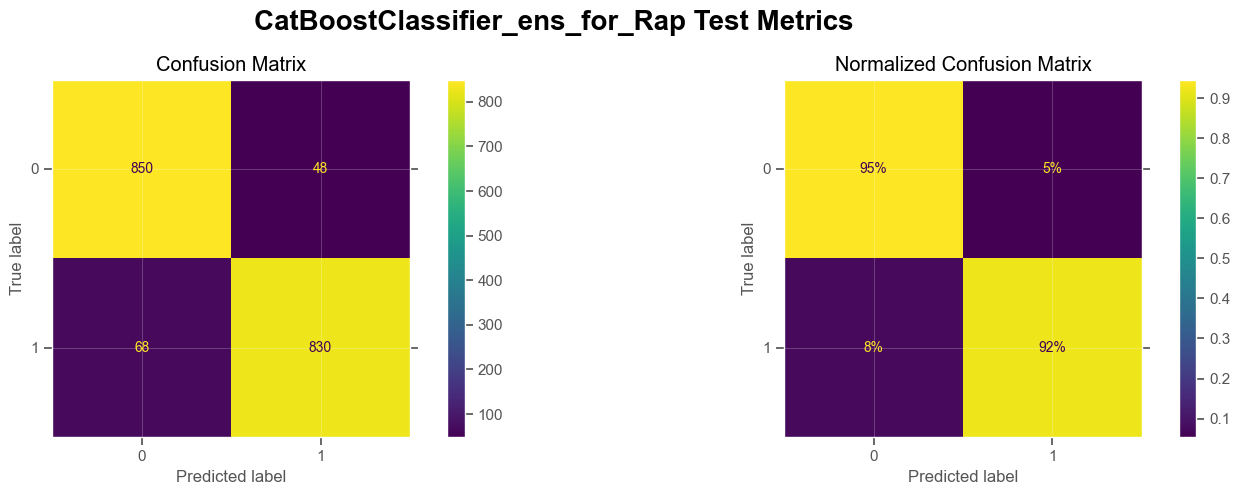


 CatBoostClassifier_ens_for_Rap Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       898
           1       0.95      0.92      0.93       898

    accuracy                           0.94      1796
   macro avg       0.94      0.94      0.94      1796
weighted avg       0.94      0.94      0.94      1796



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7712624	test: 0.7561354	best: 0.7561354 (0)	total: 17.7ms	remaining: 1m 1s
200:	learn: 0.8882159	test: 0.8791967	best: 0.8791967 (200)	total: 3.59s	remaining: 59s
400:	learn: 0.9123392	test: 0.8947258	best: 0.8964691 (340)	total: 7.38s	remaining: 57s
600:	learn: 0.9207806	test: 0.8996706	best: 0.9007978 (581)	total: 11.1s	remaining: 53.5s
800:	learn: 0.9277441	test: 0.9063970	best: 0.9063970 (800)	total: 14.8s	remaining: 49.8s
1000:	learn: 0.9338787	test: 0.9097020	best: 0.9108441 (897)	total: 18.4s	remaining: 45.9s
1200:	learn: 0.9385538	test: 0.9079876	best: 0.9108441 (897)	total: 21.9s	remaining: 42s
1400:	learn: 0.9423926	test: 0.9068586	best: 0.9108441 (897)	total: 25.6s	remaining: 38.4s
1600:	learn: 0.9449534	test: 0.9051577	best: 0.9108441 (897)	total: 29.1s	remaining: 34.5s
1800:	learn: 0.9473906	test: 0.9051427	best: 0.9108441 (897)	total: 32.5s	remaining: 30.7s
2000:	learn: 0.9487286	test: 0.9045549	best: 0.9108441 (897)	total: 35.6s	remaining: 26.7s
2200:	learn: 

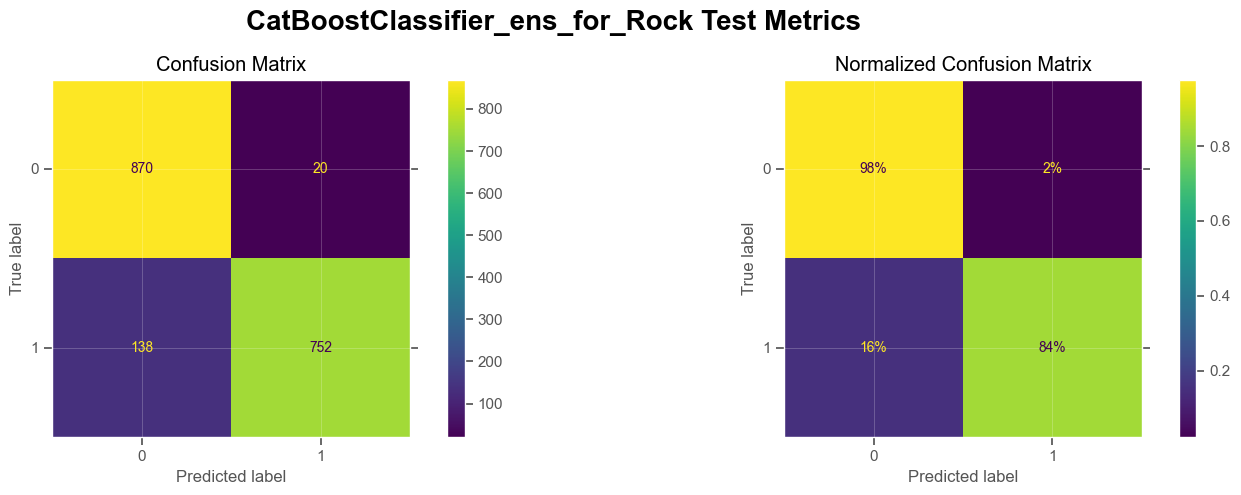


 CatBoostClassifier_ens_for_Rock Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       890
           1       0.97      0.84      0.90       890

    accuracy                           0.91      1780
   macro avg       0.92      0.91      0.91      1780
weighted avg       0.92      0.91      0.91      1780



In [122]:
model_dict = {}
for i in target_ohe.columns:
    X_train, X_test, y_train, y_test = train_test_split(X_train1.drop(columns='track_name'), y_train1[i], 
                                                    test_size=0.1, random_state=42, shuffle=True)
    
    X_train, y_train = BorderlineSMOTE().fit_resample(X_train, y_train)
    
    X_test, y_test = BorderlineSMOTE().fit_resample(X_test, y_test)
    #X_train, y_train = use_upscaling(X_train, pd.DataFrame(y_train))
    
    train_pool = Pool(X_train, y_train) #, cat_features=['key', 'mode', 'kmean',  'Birch']
    
    
    params = {
        'boosting_type': 'Ordered',
        'max_depth': 6,
        'n_estimators':3500,
        'learning_rate': 0.01,
        'thread_count': -1,
        'l2_leaf_reg': 2.0,
        'random_state': 42,
        'verbose': 200,
        'custom_metric': ['AUC', 'Accuracy'],
        'eval_metric' : 'TotalF1:average=Macro',
        'use_best_model': True
    }
    
    clf = CatBoostClassifier(**params)
    clf.fit(train_pool, eval_set=(X_test, y_test), plot=True)
    
    make_classification_plots(clf.predict(X_test), y_test, f'CatBoostClassifier_ens_for_{i}')
    
    model_dict[i] = clf
    
    

In [123]:
y_train11 =  pd.DataFrame(y_train1.idxmax(axis=1))
y_train11.columns = ['music_genre']

In [124]:
Tfidf_NB_col = Tfidf_NB(X_train1, y_train11, X_train2)

In [125]:
X_train2 = pd.concat([X_train2.reset_index(drop=True), Tfidf_NB_col], axis=1)

In [126]:
def classes_predict(data, target, model_dict, pref='cat'):
    ans_model = []
    for i in target.columns:
        pred = model_dict[i].predict_proba(data)[:, 1].T
        ans_model.append(pred)
    ans_model = np.array(ans_model) 
    ans_model = pd.DataFrame(ans_model.T, columns=[f'{col}_{pref}' for col in target.columns])
    return pd.concat([data.reset_index(drop=True), ans_model], axis=1)

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X_train2 , y_train2, 
                                                    test_size=0.1, random_state=42, shuffle=True)

In [128]:
train_ens_catboost = classes_predict(X_train.drop(columns=['Tfidf_NB', 'track_name']) , y_train, model_dict)
test_ens_catboost = classes_predict(X_test.drop(columns=['Tfidf_NB', 'track_name']), y_test, model_dict)

In [129]:
train_ens_catboost = pd.concat([train_ens_catboost, X_train['Tfidf_NB'].reset_index(drop=True)], axis=1)
test_ens_catboost = pd.concat([test_ens_catboost, X_test['Tfidf_NB'].reset_index(drop=True)], axis=1)

In [130]:
labelencoder = LabelEncoder()
train_ens_catboost['Tfidf_NB'] = labelencoder.fit_transform(train_ens_catboost['Tfidf_NB'])
test_ens_catboost['Tfidf_NB'] = labelencoder.transform(test_ens_catboost['Tfidf_NB'])

In [131]:
target_train = y_train.idxmax(axis=1)
target_test = y_test.idxmax(axis=1)

In [132]:
labelencoder = LabelEncoder()
target_train = labelencoder.fit_transform(target_train)
target_test = labelencoder.transform(target_test)

In [133]:
train_pool = Pool(train_ens_catboost, target_train) #, cat_features=['key', 'mode', 'kmean']

In [134]:
params = {
        'boosting_type': 'Ordered',
        'max_depth': 6,
        'n_estimators':3000,
        'learning_rate': 0.01,
        'thread_count': -1,
        'l2_leaf_reg': 3.0,
        'random_state': 42,
        'verbose': 200,
        'custom_metric': ['AUC', 'Accuracy'],
        'eval_metric' : 'TotalF1:average=Macro',
        'use_best_model': True
    }

train_pool = Pool(train_ens_catboost, target_train)
clf = CatBoostClassifier(**params)
clf.fit(train_pool, eval_set=(test_ens_catboost,  target_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3312449	test: 0.3236017	best: 0.3236017 (0)	total: 147ms	remaining: 7m 21s
200:	learn: 0.4566745	test: 0.4629156	best: 0.4629156 (199)	total: 31.1s	remaining: 7m 12s
400:	learn: 0.4919432	test: 0.4960951	best: 0.4968161 (396)	total: 1m 1s	remaining: 6m 41s
600:	learn: 0.5056418	test: 0.5073305	best: 0.5073709 (593)	total: 1m 33s	remaining: 6m 12s
800:	learn: 0.5159472	test: 0.5044756	best: 0.5090389 (697)	total: 2m 4s	remaining: 5m 41s
1000:	learn: 0.5247302	test: 0.5042212	best: 0.5090389 (697)	total: 2m 35s	remaining: 5m 11s
1200:	learn: 0.5305936	test: 0.5088067	best: 0.5090389 (697)	total: 3m 7s	remaining: 4m 40s
1400:	learn: 0.5385861	test: 0.5116560	best: 0.5116560 (1387)	total: 3m 38s	remaining: 4m 9s
1600:	learn: 0.5481951	test: 0.5115820	best: 0.5116560 (1387)	total: 4m 10s	remaining: 3m 39s
1800:	learn: 0.5563198	test: 0.5153295	best: 0.5153684 (1773)	total: 4m 42s	remaining: 3m 8s
2000:	learn: 0.5644607	test: 0.5115940	best: 0.5153848 (1825)	total: 5m 15s	remaini

[Summary Statistics]
Accuracy = 53.92% | Balanced Accuracy = 52.10% | Precision = 54.36% | Recall = 53.92% | F1-Score = 52.50% | fbeta = 53.04%


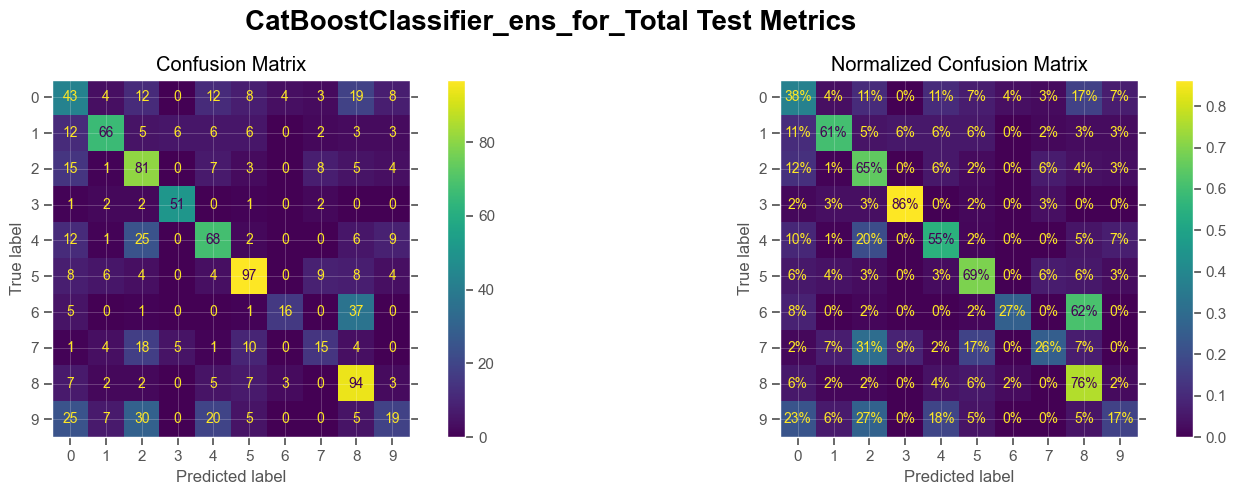


 CatBoostClassifier_ens_for_Total Classification Report: 
               precision    recall  f1-score   support

           0       0.33      0.38      0.36       113
           1       0.71      0.61      0.65       109
           2       0.45      0.65      0.53       124
           3       0.82      0.86      0.84        59
           4       0.55      0.55      0.55       123
           5       0.69      0.69      0.69       140
           6       0.70      0.27      0.39        60
           7       0.38      0.26      0.31        58
           8       0.52      0.76      0.62       123
           9       0.38      0.17      0.24       111

    accuracy                           0.54      1020
   macro avg       0.55      0.52      0.52      1020
weighted avg       0.54      0.54      0.53      1020



In [135]:
make_classification_plots(clf.predict(test_ens_catboost), target_test, f'CatBoostClassifier_ens_for_Total')

['Electronic_cat', 'Blues_cat', 'Rap_cat', 'Anime_cat', 'Country_cat', 'Classical_cat', 'Hip-Hop_cat', 'Jazz_cat', 'Alternative_cat', 'Rock_cat', 'acousticness', 'instrumentalness', 'loudness', 'danceability', 'speechiness', 'Tfidf_NB', 'energy', 'track_name_looe', 'valence', 'tempo', 'duration_ms', 'instrumental', 'liveness', 'language', 'track_name_lenght', 'danceability_category', 'loudness/energy', 'key', 'energy_category', 'track_name_words', 'danceability/energy', 'modality', 'liveness_type', 'mood', 'loudness/liveness', 'speechiness_type']


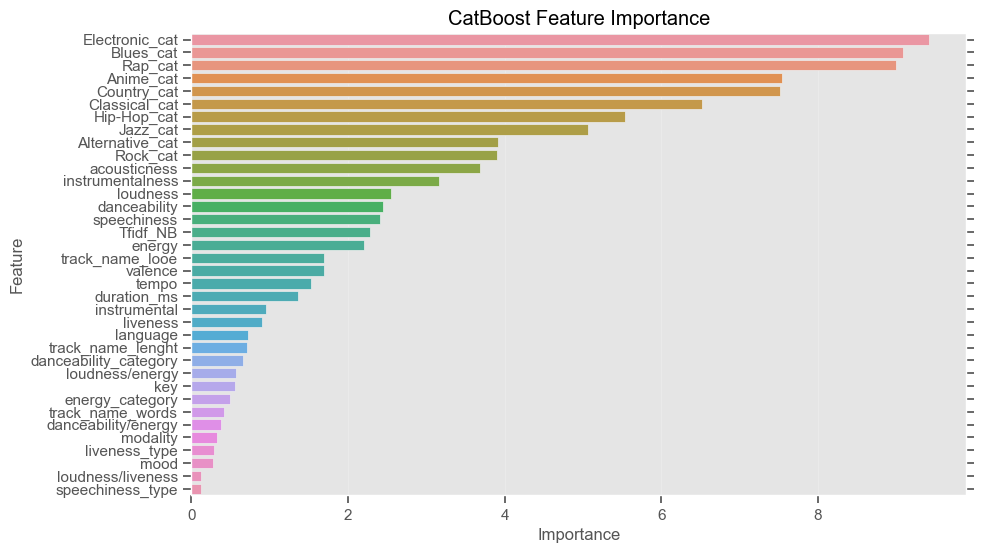

In [136]:
results = list(zip(train_ens_catboost, clf.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
se.barplot(x = importance.Importance, y = importance.Feature)
plt.title("CatBoost Feature Importance")

print(importance.Feature.tolist())

#### Create Submition

In [137]:
test1 = test.copy()

In [ ]:
index = test1['instance_id']

In [ ]:
tt = pd.DataFrame(labelencoder.inverse_transform(target))
tt.columns = ['music_genre']

In [ ]:
Tfidf_NB_col_test = Tfidf_NB(train,tt, test1)

In [ ]:
test1.drop(columns='track_name', inplace=True)
test1.set_index('instance_id', drop=True, inplace=True)

In [ ]:
test1 = classes_predict(test1, y_train, model_dict)

In [ ]:
test1 = pd.concat([test1.reset_index(drop=True), Tfidf_NB_col.reset_index(drop=True)], axis=1)

In [ ]:
test1['Tfidf_NB'] = labelencoder.transform(test1['Tfidf_NB'])

In [ ]:
answer = pd.DataFrame(labelencoder.inverse_transform(clf.predict(test1)))

In [ ]:
answer.index = index
answer.columns = ['music_genre']

In [ ]:
answer.head()

In [ ]:
answer.to_csv('21.csv')

##  LGBM

### LGBMClassifier

In [138]:
import lightgbm as lgb

In [141]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns='track_name'), target, 
                                                test_size=0.1, random_state=42, shuffle=True)

In [142]:
lgbm = lgb.LGBMClassifier(random_state=0, learning_rate=0.01, n_estimators=5000)
lgbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.01, n_estimators=5000, random_state=0)

[Summary Statistics]
Accuracy = 49.61% | Balanced Accuracy = 48.68% | Precision = 49.57% | Recall = 49.61% | F1-Score = 48.80% | fbeta = 49.03%


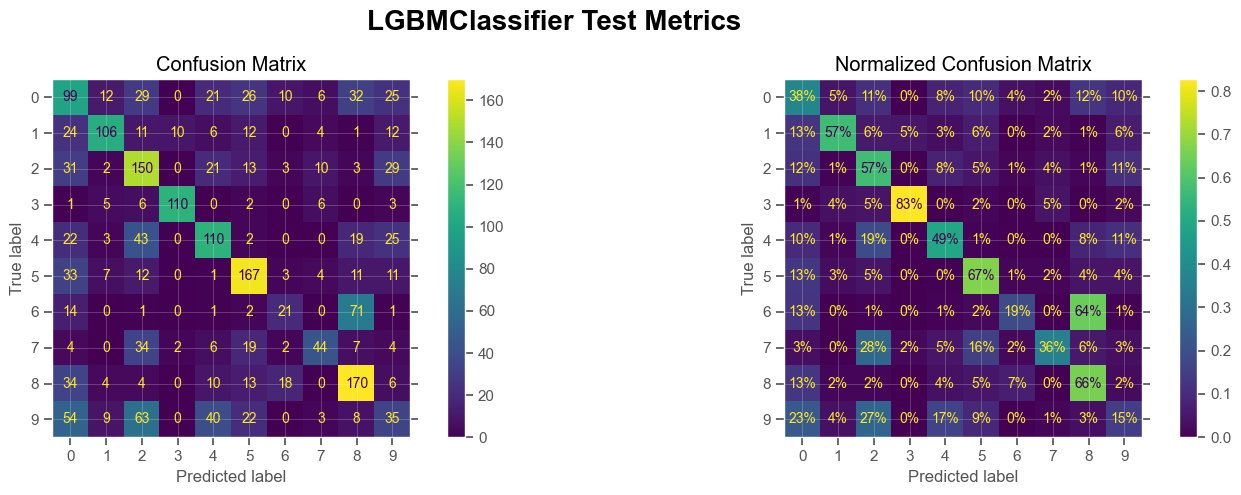


 LGBMClassifier Classification Report: 
               precision    recall  f1-score   support

           0       0.31      0.38      0.34       260
           1       0.72      0.57      0.63       186
           2       0.42      0.57      0.49       262
           3       0.90      0.83      0.86       133
           4       0.51      0.49      0.50       224
           5       0.60      0.67      0.63       249
           6       0.37      0.19      0.25       111
           7       0.57      0.36      0.44       122
           8       0.53      0.66      0.59       259
           9       0.23      0.15      0.18       234

    accuracy                           0.50      2040
   macro avg       0.52      0.49      0.49      2040
weighted avg       0.50      0.50      0.49      2040



In [143]:
make_classification_plots(lgbm.predict(X_test), y_test, 'LGBMClassifier')

#### Creat Submition

In [ ]:
test1 = test.copy()
test1.set_index('instance_id', drop=True, inplace=True)

In [ ]:
answer = lgbm.predict(test1)

In [ ]:
answer = pd.DataFrame(labelencoder.inverse_transform(answer))
answer

In [ ]:
answer.index = test1.index

In [ ]:
answer.columns = ['music_genre']

In [ ]:
answer.to_csv('2.csv')

### Ансамбль LGBM, один против всех

In [144]:
#OHE
target_str = labelencoder.inverse_transform(target)
target_ohe = pd.get_dummies(target_str)

In [145]:
target_ohe.columns

Index(['Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic',
       'Hip-Hop', 'Jazz', 'Rap', 'Rock'],
      dtype='object')

In [146]:
#Разделили данные на две половины
X_train1, X_train2, y_train1, y_train2 = train_test_split(train, target_ohe, 
                                                    test_size=0.45, random_state=42, shuffle=True)

[Summary Statistics]
Accuracy = 51.47% | Balanced Accuracy = 51.47% | Precision = 64.86% | Recall = 51.47% | F1-Score = 37.36% | fbeta = 36.45%


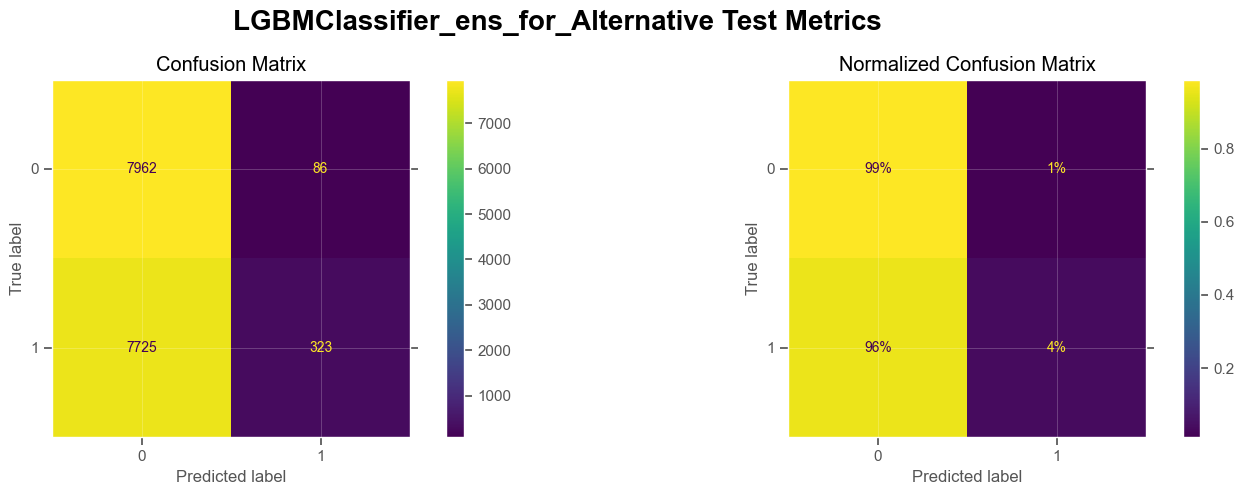


 LGBMClassifier_ens_for_Alternative Classification Report: 
               precision    recall  f1-score   support

           0       0.51      0.99      0.67      8048
           1       0.79      0.04      0.08      8048

    accuracy                           0.51     16096
   macro avg       0.65      0.51      0.37     16096
weighted avg       0.65      0.51      0.37     16096

[Summary Statistics]
Accuracy = 67.14% | Balanced Accuracy = 67.14% | Precision = 79.05% | Recall = 67.14% | F1-Score = 63.39% | fbeta = 68.79%


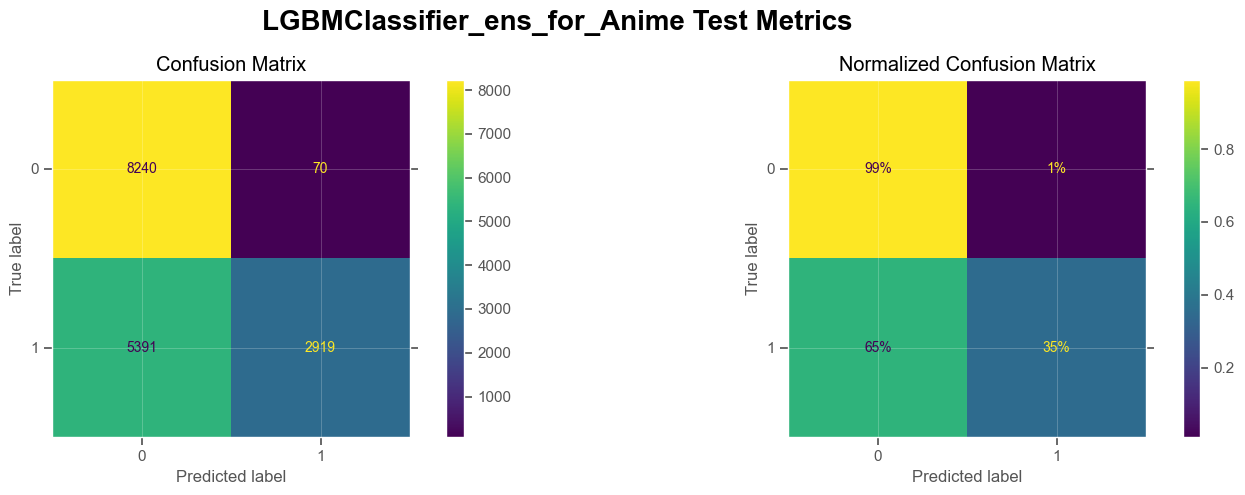


 LGBMClassifier_ens_for_Anime Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.99      0.75      8310
           1       0.98      0.35      0.52      8310

    accuracy                           0.67     16620
   macro avg       0.79      0.67      0.63     16620
weighted avg       0.79      0.67      0.63     16620

[Summary Statistics]
Accuracy = 63.60% | Balanced Accuracy = 63.60% | Precision = 75.04% | Recall = 63.60% | F1-Score = 58.90% | fbeta = 64.05%


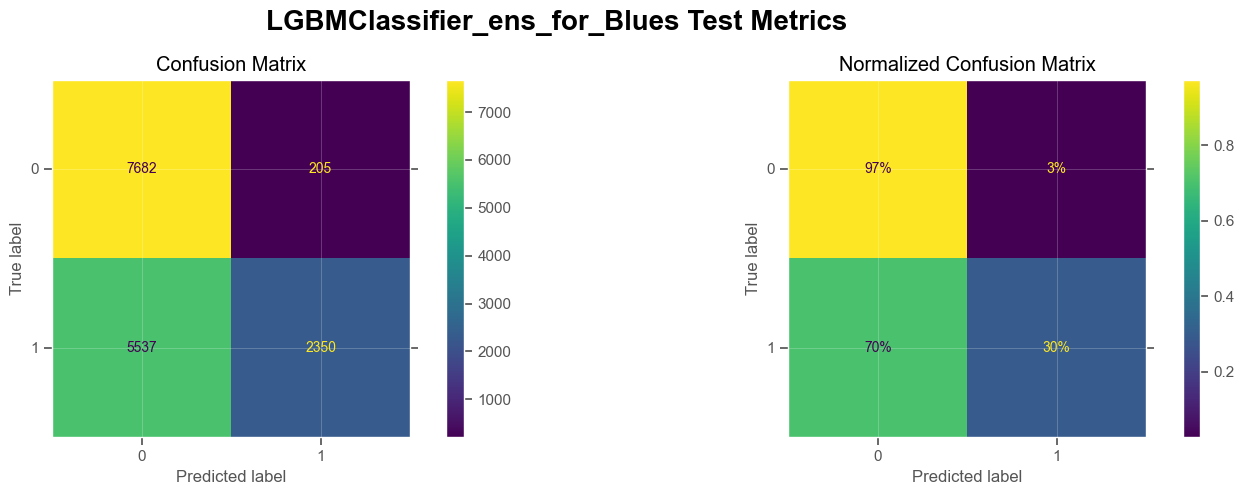


 LGBMClassifier_ens_for_Blues Classification Report: 
               precision    recall  f1-score   support

           0       0.58      0.97      0.73      7887
           1       0.92      0.30      0.45      7887

    accuracy                           0.64     15774
   macro avg       0.75      0.64      0.59     15774
weighted avg       0.75      0.64      0.59     15774

[Summary Statistics]
Accuracy = 92.70% | Balanced Accuracy = 92.70% | Precision = 93.48% | Recall = 92.70% | F1-Score = 92.67% | fbeta = 93.05%


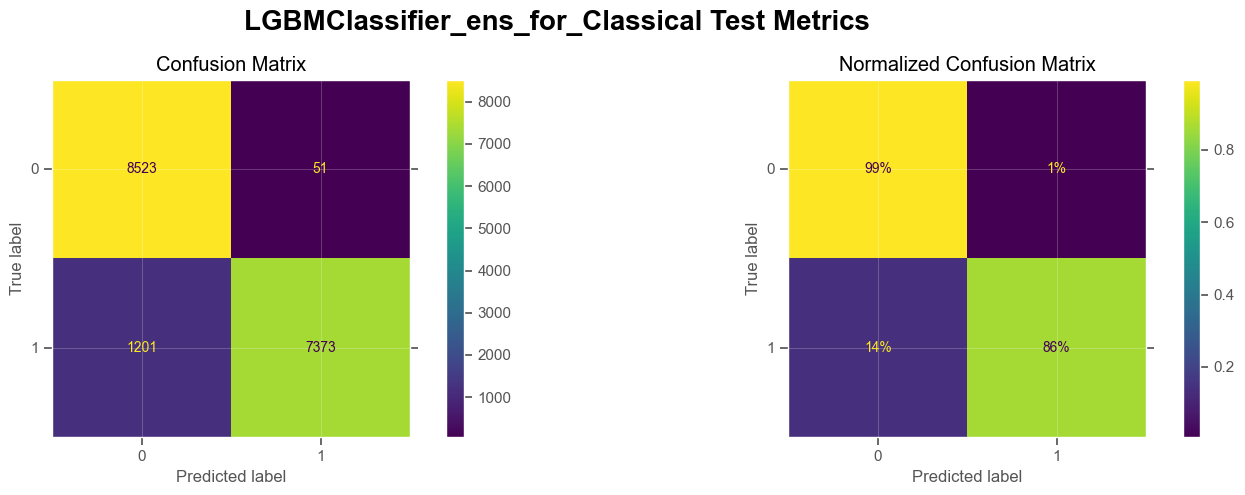


 LGBMClassifier_ens_for_Classical Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      8574
           1       0.99      0.86      0.92      8574

    accuracy                           0.93     17148
   macro avg       0.93      0.93      0.93     17148
weighted avg       0.93      0.93      0.93     17148

[Summary Statistics]
Accuracy = 64.18% | Balanced Accuracy = 64.18% | Precision = 76.15% | Recall = 64.18% | F1-Score = 59.54% | fbeta = 64.87%


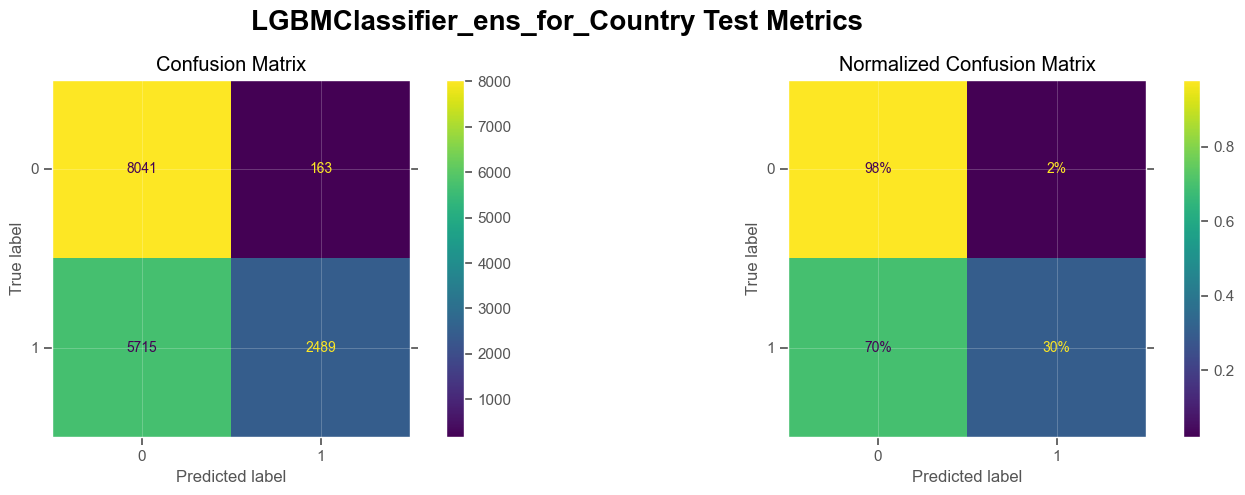


 LGBMClassifier_ens_for_Country Classification Report: 
               precision    recall  f1-score   support

           0       0.58      0.98      0.73      8204
           1       0.94      0.30      0.46      8204

    accuracy                           0.64     16408
   macro avg       0.76      0.64      0.60     16408
weighted avg       0.76      0.64      0.60     16408

[Summary Statistics]
Accuracy = 74.70% | Balanced Accuracy = 74.70% | Precision = 81.01% | Recall = 74.70% | F1-Score = 73.34% | fbeta = 76.53%


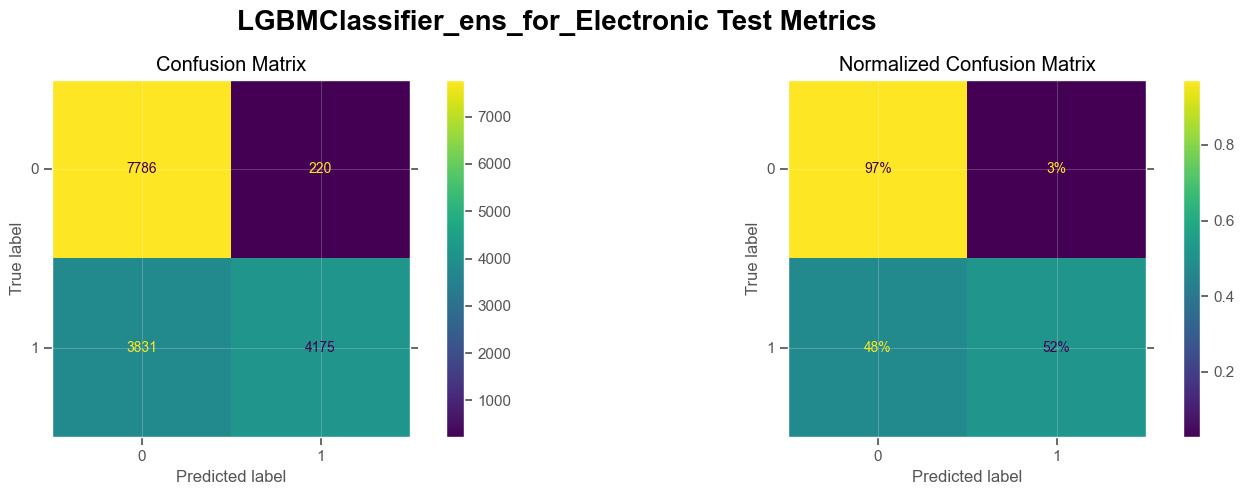


 LGBMClassifier_ens_for_Electronic Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.97      0.79      8006
           1       0.95      0.52      0.67      8006

    accuracy                           0.75     16012
   macro avg       0.81      0.75      0.73     16012
weighted avg       0.81      0.75      0.73     16012

[Summary Statistics]
Accuracy = 54.10% | Balanced Accuracy = 54.10% | Precision = 74.55% | Recall = 54.10% | F1-Score = 42.02% | fbeta = 44.50%


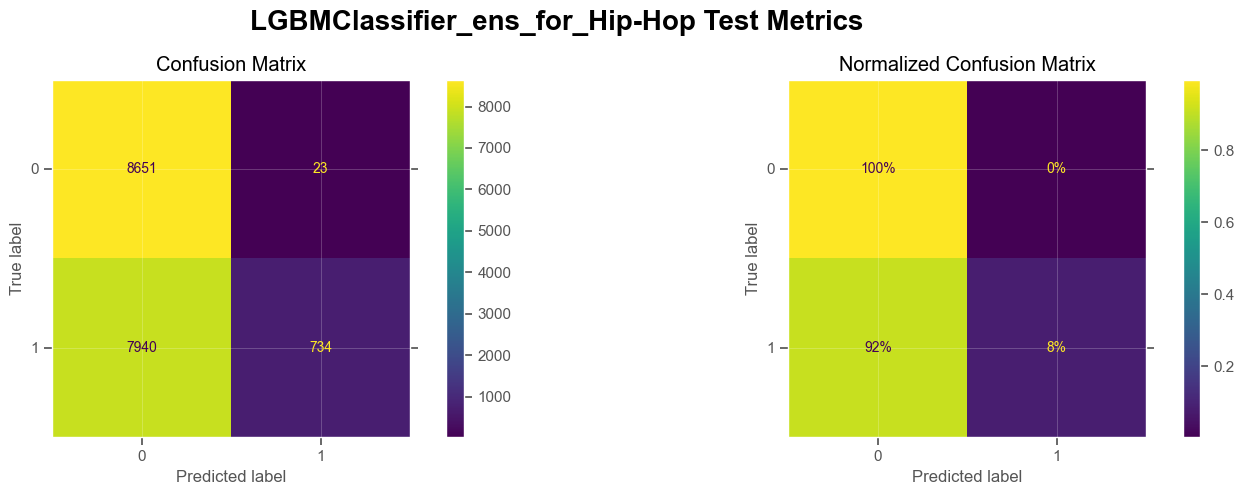


 LGBMClassifier_ens_for_Hip-Hop Classification Report: 
               precision    recall  f1-score   support

           0       0.52      1.00      0.68      8674
           1       0.97      0.08      0.16      8674

    accuracy                           0.54     17348
   macro avg       0.75      0.54      0.42     17348
weighted avg       0.75      0.54      0.42     17348

[Summary Statistics]
Accuracy = 57.24% | Balanced Accuracy = 57.24% | Precision = 75.45% | Recall = 57.24% | F1-Score = 47.92% | fbeta = 52.79%


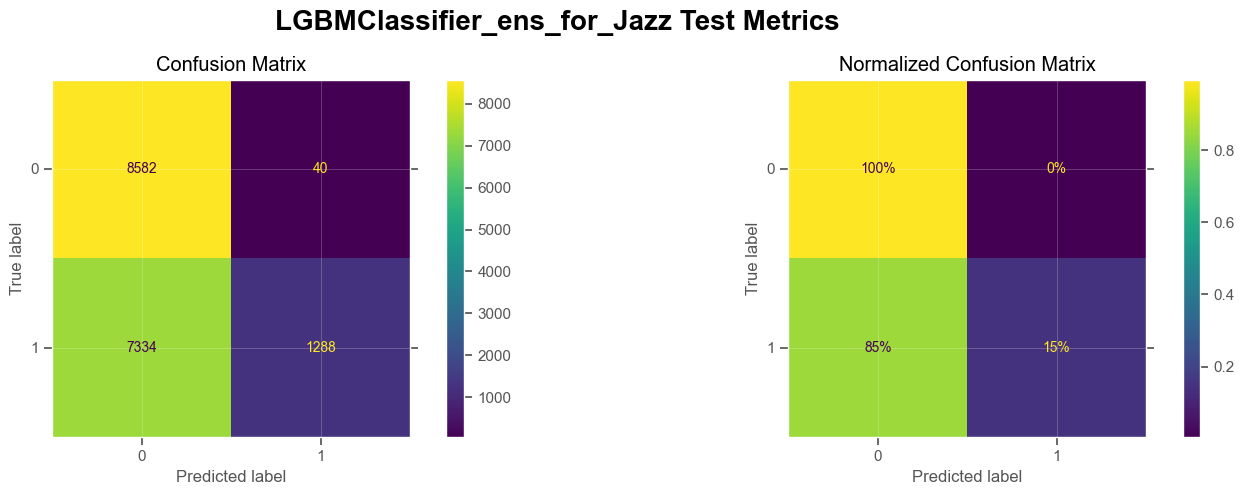


 LGBMClassifier_ens_for_Jazz Classification Report: 
               precision    recall  f1-score   support

           0       0.54      1.00      0.70      8622
           1       0.97      0.15      0.26      8622

    accuracy                           0.57     17244
   macro avg       0.75      0.57      0.48     17244
weighted avg       0.75      0.57      0.48     17244

[Summary Statistics]
Accuracy = 69.87% | Balanced Accuracy = 69.87% | Precision = 77.57% | Recall = 69.87% | F1-Score = 67.61% | fbeta = 71.47%


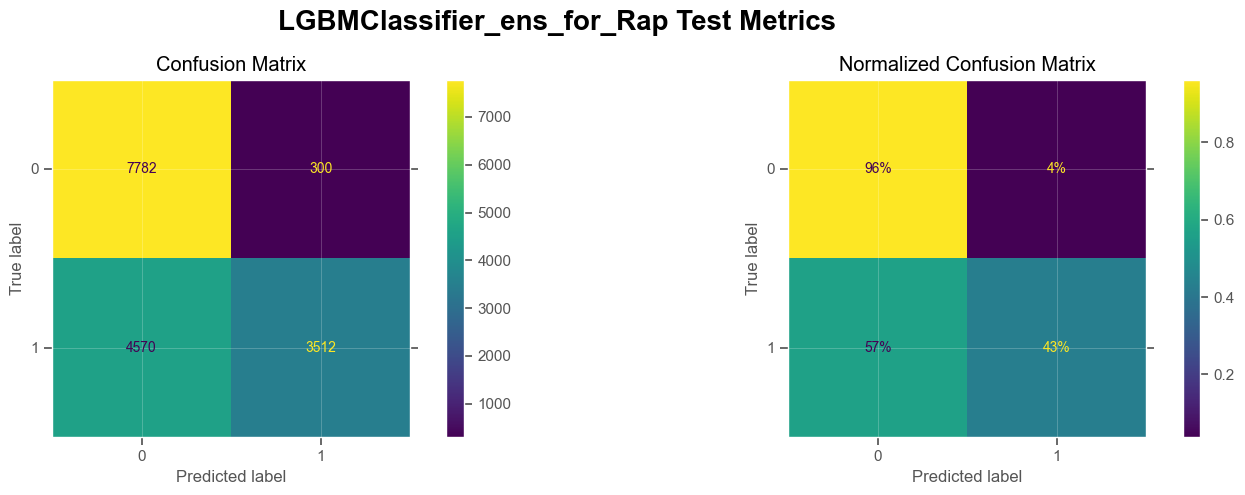


 LGBMClassifier_ens_for_Rap Classification Report: 
               precision    recall  f1-score   support

           0       0.63      0.96      0.76      8082
           1       0.92      0.43      0.59      8082

    accuracy                           0.70     16164
   macro avg       0.78      0.70      0.68     16164
weighted avg       0.78      0.70      0.68     16164

[Summary Statistics]
Accuracy = 51.41% | Balanced Accuracy = 51.41% | Precision = 68.93% | Recall = 51.41% | F1-Score = 36.78% | fbeta = 35.29%


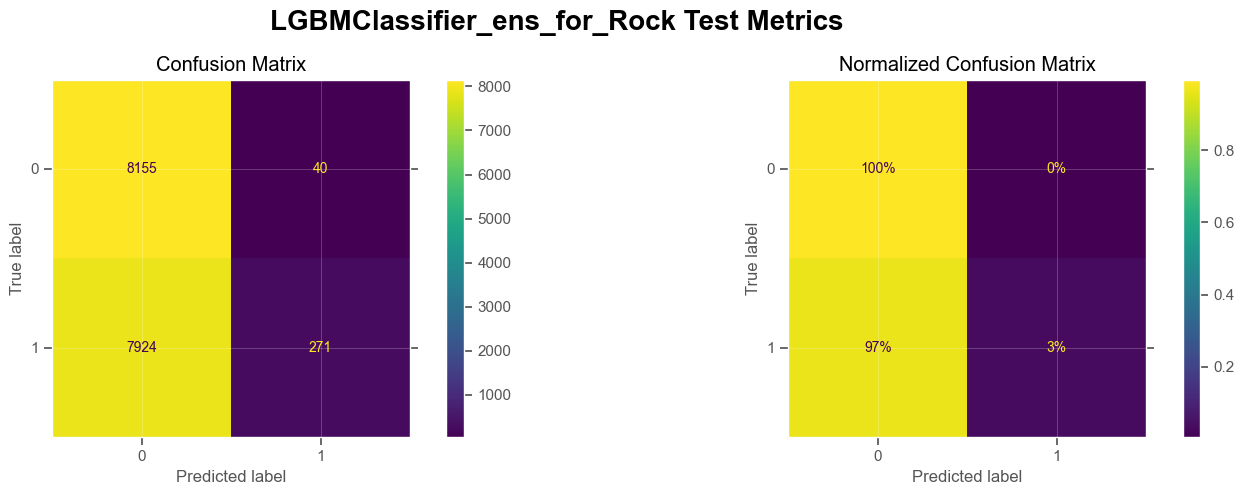


 LGBMClassifier_ens_for_Rock Classification Report: 
               precision    recall  f1-score   support

           0       0.51      1.00      0.67      8195
           1       0.87      0.03      0.06      8195

    accuracy                           0.51     16390
   macro avg       0.69      0.51      0.37     16390
weighted avg       0.69      0.51      0.37     16390



In [150]:
model_dict_LGBM = {}
for i in target_ohe.columns:
    
    X_test, y_test = BorderlineSMOTE().fit_resample(X_train2.drop(columns='track_name'), y_train2[i])
    
    
    lgbm = lgb.LGBMClassifier(random_state=0,  n_jobs = -1, learning_rate=0.01, n_estimators=4000)
    
    grid = GridSearchCV(estimator= lgbm,
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss', 'rf']}, cv=3, scoring='f1_micro')
    
    grid.fit(X_train1.drop(columns='track_name'), y_train1[i])
    make_classification_plots(grid.predict(X_test), y_test, f'LGBMClassifier_ens_for_{i}')
    
    model_dict_LGBM[i] = grid

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X_train2.drop(columns='track_name'), y_train2, 
                                                    test_size=0.1, random_state=42, shuffle=True)

In [155]:
#X_train, y_train = use_upscaling(X_train, y_train)
#X_train, y_train  = BorderlineSMOTE().fit_resample(X_train, y_train)

In [156]:
train_ans = classes_predict(X_train, y_train, model_dict_LGBM)
test_ans = classes_predict(X_test, y_test, model_dict_LGBM)

In [157]:
target_train = y_train.idxmax(axis=1)
target_test = y_test.idxmax(axis=1)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3887101	test: 0.3990917	best: 0.3990917 (0)	total: 146ms	remaining: 8m 29s
200:	learn: 0.4551252	test: 0.4513896	best: 0.4519817 (179)	total: 30.5s	remaining: 8m 19s
400:	learn: 0.4922109	test: 0.4684309	best: 0.4684309 (396)	total: 1m	remaining: 7m 50s
600:	learn: 0.5062972	test: 0.4745662	best: 0.4754287 (547)	total: 1m 31s	remaining: 7m 19s
800:	learn: 0.5144995	test: 0.4770837	best: 0.4800994 (747)	total: 2m 1s	remaining: 6m 48s
1000:	learn: 0.5188514	test: 0.4765198	best: 0.4800994 (747)	total: 2m 31s	remaining: 6m 18s
1200:	learn: 0.5274346	test: 0.4861598	best: 0.4861811 (1186)	total: 3m 4s	remaining: 5m 52s
1400:	learn: 0.5341239	test: 0.4838165	best: 0.4861811 (1186)	total: 3m 37s	remaining: 5m 25s
1600:	learn: 0.5438519	test: 0.4843435	best: 0.4861811 (1186)	total: 4m 7s	remaining: 4m 53s
1800:	learn: 0.5522375	test: 0.4864753	best: 0.4878582 (1726)	total: 4m 38s	remaining: 4m 22s
2000:	learn: 0.5593396	test: 0.4881204	best: 0.4881204 (1991)	total: 5m 9s	remaining

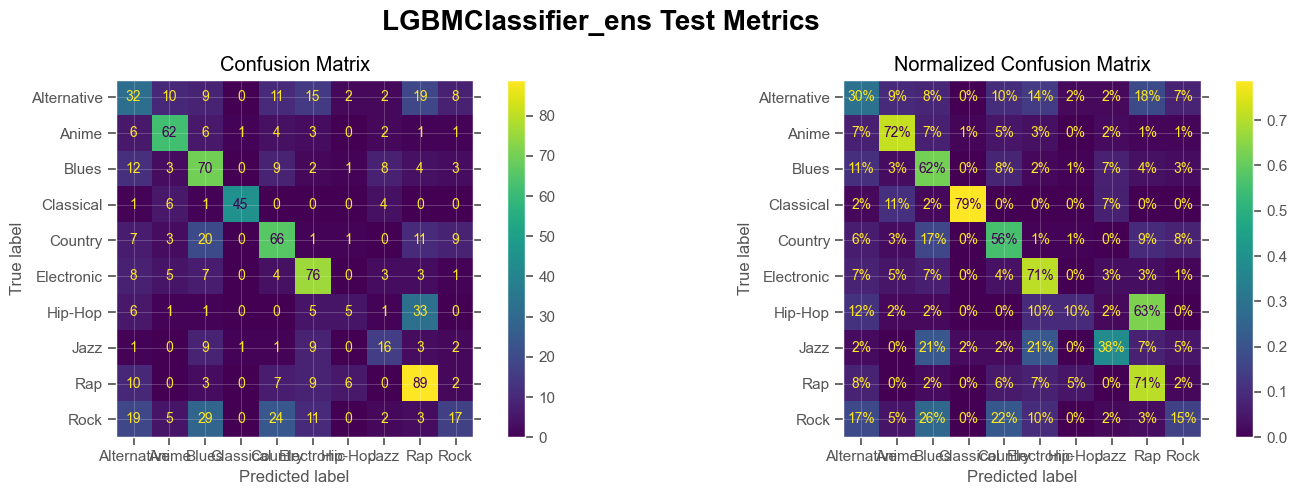


 LGBMClassifier_ens Classification Report: 
               precision    recall  f1-score   support

 Alternative       0.31      0.30      0.30       108
       Anime       0.65      0.72      0.69        86
       Blues       0.45      0.62      0.52       112
   Classical       0.96      0.79      0.87        57
     Country       0.52      0.56      0.54       118
  Electronic       0.58      0.71      0.64       107
     Hip-Hop       0.33      0.10      0.15        52
        Jazz       0.42      0.38      0.40        42
         Rap       0.54      0.71      0.61       126
        Rock       0.40      0.15      0.22       110

    accuracy                           0.52       918
   macro avg       0.52      0.50      0.49       918
weighted avg       0.51      0.52      0.50       918



In [158]:
params = {
        'boosting_type': 'Ordered',
        'max_depth': 6,
        'n_estimators':3500,
        'learning_rate': 0.01,
        'thread_count': -1,
        'l2_leaf_reg': 3.0,
        'random_state': 42,
        'verbose': 200,
        'custom_metric': ['AUC', 'Accuracy'],
        'eval_metric' : 'TotalF1:average=Macro',
        'use_best_model': True
    }

train_pool = Pool(train_ans, target_train) 
clf = CatBoostClassifier(**params)
clf.fit(train_pool, eval_set=(test_ans,  target_test), plot=True)
make_classification_plots(clf.predict(test_ans), target_test, f'LGBMClassifier_ens')

Text(0.5, 1.0, 'CatBoost Feature Importance')

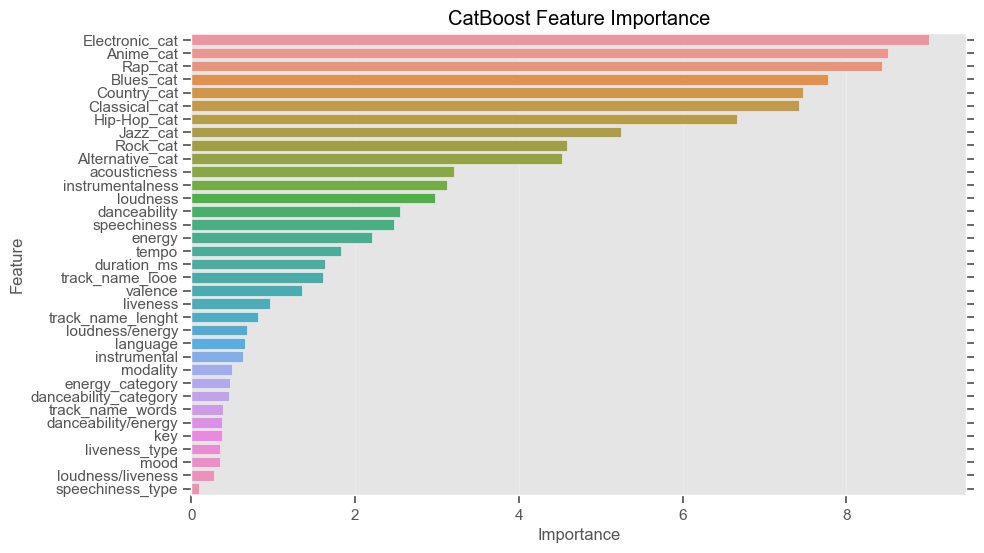

In [159]:
results = list(zip(train_ans, clf.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
se.barplot(x = importance.Importance, y = importance.Feature)
plt.title("CatBoost Feature Importance")

#### Create Submition

In [ ]:
test1 = test.copy()
test1.drop(columns='track_name', inplace=True)
test1.set_index('instance_id', drop=True, inplace=True)

In [ ]:
answer = classes_predict(test1, y_train, model_dict_LGBM)

In [ ]:
answer = pd.DataFrame(clf.predict(answer))
answer.index = test1.index
answer.columns = ['music_genre']

In [ ]:
answer.to_csv('16.csv')

### Сложение двух ансамблей

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train2, y_train2, 
                                                    test_size=0.1, random_state=42, shuffle=True)

In [ ]:
train_catboost = classes_predict(X_train, y_train, model_dict, pref='cat')
test_catboost = classes_predict(X_test, y_test, model_dict, pref='cat')

In [ ]:
train_lgbm = classes_predict(X_train, y_train, model_dict_LGBM, pref='lgbm')
test_lgbm = classes_predict(X_test, y_test, model_dict_LGBM, pref='lgbm')

In [ ]:
train_sum = pd.concat([train_catboost.reset_index(drop=True), train_lgbm.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
test_sum = pd.concat([test_catboost.reset_index(drop=True), test_lgbm.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)

In [ ]:
train_sum = train_sum.T.drop_duplicates().T
test_sum = test_sum.T.drop_duplicates().T

In [ ]:
params = {
        'boosting_type': 'Ordered',
        'max_depth': 6,
        'n_estimators':3500,
        'learning_rate': 0.01,
        'thread_count': -1,
        'l2_leaf_reg': 3.0,
        'random_state': 42,
        'verbose': 200,
        'custom_metric': ['AUC', 'Accuracy'],
        'eval_metric' : 'TotalF1:average=Macro',
        'use_best_model': True
    }

train_pool = Pool(train_sum, target_train) 
clf = CatBoostClassifier(**params)
clf.fit(train_pool, eval_set=(test_sum,  target_test), plot=True)
make_classification_plots(clf.predict(test_sum), target_test, f'LGBMClassifier_ens')

#### Create Submition

In [ ]:
test1 = test.copy()
test1.drop(columns='track_name', inplace=True)
test1.set_index('instance_id', drop=True, inplace=True)

In [ ]:
answer_LGBM = classes_predict(test1, y_train, model_dict, pref='cat')
answer_catboost = classes_predict(test1, y_train, model_dict_LGBM, pref='lgbm')

In [ ]:
test_sum = pd.concat([answer_catboost.reset_index(drop=True), answer_LGBM.reset_index(drop=True), test1.reset_index(drop=True)], axis=1)

In [ ]:
test_sum = test_sum.T.drop_duplicates().T

In [ ]:
answer = pd.DataFrame(clf.predict(test_sum))
answer.index = test1.index
answer.columns = ['music_genre']

In [ ]:
answer.to_csv('18.csv')

In [ ]:
answer

## All vs All

In [ ]:
train, target, test, labelencoder = get_good_data()

le = LabelEncoder()
looe = LeaveOneOutEncoder()
pt = PowerTransformer(copy=False)
rs = RobustScaler()

for col in cat_features+['danceability_category', 'energy_category']:
    train[col]  = le.fit_transform(train[col])
    test[col]  = le.transform(test[col])

    
target = le.fit_transform(target)

train['track_name']= looe.fit_transform(train['track_name'], target)
test['track_name']= looe.transform(test['track_name'])

train[skewedFeatures] = pt.fit_transform(train[skewedFeatures])
test[skewedFeatures] = pt.transform(test[skewedFeatures])

train[skewedFeatures] = rs.fit_transform(train[skewedFeatures])
test[skewedFeatures] = rs.transform(test[skewedFeatures])

In [160]:
target = labelencoder.inverse_transform(target)
target = pd.get_dummies(target)

In [161]:
columns = target.columns

In [162]:
def to_binary(data, target, class1, class2):
    good_index = target[(target[class1] == 1) | (target[class2] == 1)].index
    data = data.loc[good_index]
    target = target.loc[good_index][[class1, class2]]
    target = target.idxmax(axis=1)
    le = LabelEncoder()
    target = le.fit_transform(target)
    return data, target, le

In [163]:
def to_binary_test(data, target, class1, class2):
    target = target[[class1, class2]]
    target = target.idxmax(axis=1)
    display(target)
    le = LabelEncoder()
    target = le.fit_transform(target)
    return data, target, le

In [167]:
X_Train_1, X_Train_2, y_train_1, y_test_2 = train_test_split(train.drop(columns='track_name'), target, 
                                                    test_size=0.4, random_state=42, shuffle=True)

In [168]:
pvp_result = {}
LabelEncoders = {}

for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        print(columns[i], columns[j])
        
        train_data, tar_train, le = to_binary(X_Train_1.copy(), y_train_1.copy(), columns[i], columns[j])
        train_data, tar_train  = BorderlineSMOTE().fit_resample(train_data, tar_train)
        LabelEncoders[f'{columns[i]}_vs_{columns[j]}'] = le
        
        LGBM = lgb.LGBMClassifier(random_state=42, learning_rate=0.01, n_estimators=4000)
    

        grid = GridSearchCV(estimator= LGBM,
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss', 'rf']}, cv=3, scoring='f1_micro')

        grid.fit(train_data, tar_train)
        print(grid.best_score_)
        
        print(grid.best_estimator_)
        pvp_result[f'{columns[i]}_vs_{columns[j]}'] = grid
        
        

Alternative Anime
0.8162142445315167
LGBMClassifier(boosting_type='goss', learning_rate=0.01, n_estimators=4000,
               random_state=42)
Alternative Blues
0.7758118590835131
LGBMClassifier(boosting_type='goss', learning_rate=0.01, n_estimators=4000,
               random_state=42)
Alternative Classical
0.9574193700212974
LGBMClassifier(boosting_type='goss', learning_rate=0.01, n_estimators=4000,
               random_state=42)
Alternative Country
0.8027598338569429
LGBMClassifier(boosting_type='goss', learning_rate=0.01, n_estimators=4000,
               random_state=42)
Alternative Electronic
0.8149672891148058
LGBMClassifier(boosting_type='goss', learning_rate=0.01, n_estimators=4000,
               random_state=42)
Alternative Hip-Hop
0.8716480167555037
LGBMClassifier(boosting_type='goss', learning_rate=0.01, n_estimators=4000,
               random_state=42)
Alternative Jazz
0.895442538270559
LGBMClassifier(boosting_type='goss', learning_rate=0.01, n_estimators=4000,
      

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X_Train_2, y_test_2, 
                                                    test_size=0.1, random_state=42, shuffle=True)

#X_train, y_train = use_upscaling(X_train, y_train)

In [170]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [171]:
pred_train = []
pred_test = []
res_columns = []

for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        res_columns.append(f'{columns[i]}_vs_{columns[j]}')
        pred_test.append(pvp_result[f'{columns[i]}_vs_{columns[j]}'].predict_proba(X_test)[:,1].T)
        pred_train.append(pvp_result[f'{columns[i]}_vs_{columns[j]}'].predict_proba(X_train)[:,1].T)



In [172]:
train_ens = pd.DataFrame(np.array(pred_train).T)
test_ens = pd.DataFrame(np.array(pred_test).T)

In [173]:
train_ens = pd.concat([train_ens, X_train], axis=1)
test_ens = pd.concat([test_ens.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)

In [174]:
target_train = y_train.idxmax(axis=1)
target_test = y_test.idxmax(axis=1)

In [175]:
params = {
        'boosting_type': 'Ordered',
        'max_depth': 6,
        'n_estimators':3000,
        'learning_rate': 0.01,
        'thread_count': -1,
        'l2_leaf_reg': 3.0,
        'random_state': 42,
        'verbose': 500,
        'custom_metric': ['AUC', 'Accuracy'],
        'eval_metric' : 'TotalF1:average=Macro',
        'use_best_model': True
    }

train_pool = Pool(train_ens,  target_train)
clf = CatBoostClassifier(**params)
clf.fit(train_pool, eval_set=(test_ens,  target_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3321412	test: 0.3210470	best: 0.3210470 (0)	total: 313ms	remaining: 15m 37s
500:	learn: 0.4941873	test: 0.4716835	best: 0.4733942 (458)	total: 2m 51s	remaining: 14m 13s
1000:	learn: 0.5280506	test: 0.4927478	best: 0.4937173 (977)	total: 5m 39s	remaining: 11m 18s
1500:	learn: 0.5504640	test: 0.4968240	best: 0.5006073 (1069)	total: 8m 31s	remaining: 8m 30s
2000:	learn: 0.5706329	test: 0.5019868	best: 0.5035135 (1964)	total: 11m 24s	remaining: 5m 41s
2500:	learn: 0.5948128	test: 0.5075900	best: 0.5096898 (2300)	total: 14m 17s	remaining: 2m 51s
2999:	learn: 0.6177214	test: 0.5116220	best: 0.5134452 (2750)	total: 17m 11s	remaining: 0us

bestTest = 0.5134452271
bestIteration = 2750

Shrink model to first 2751 iterations.


[Summary Statistics]
Accuracy = 53.68% | Balanced Accuracy = 51.93% | Precision = 53.44% | Recall = 53.68% | F1-Score = 52.07% | fbeta = 52.29%


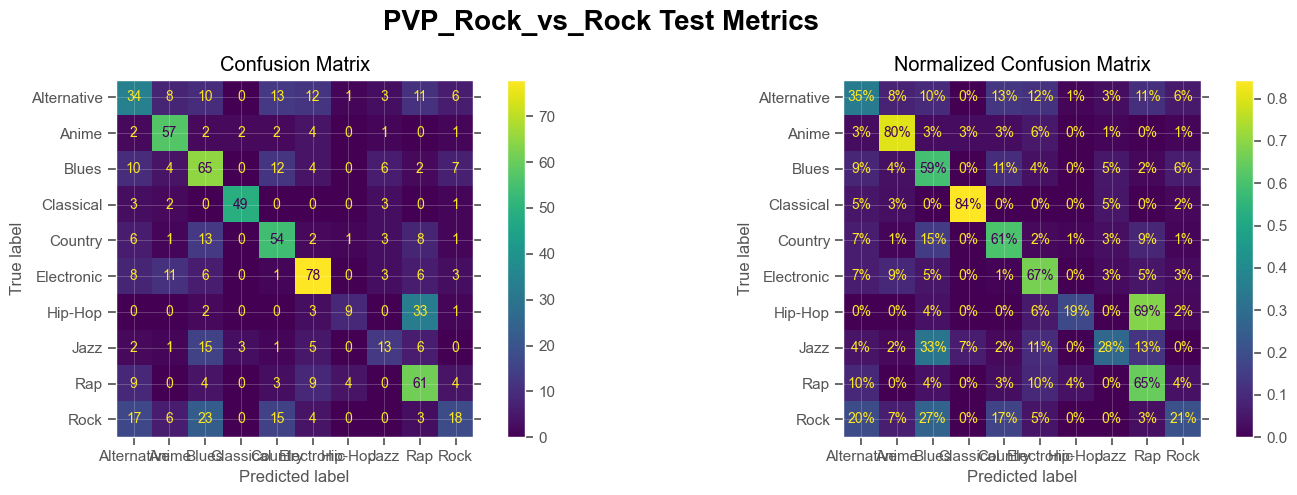


 PVP_Rock_vs_Rock Classification Report: 
               precision    recall  f1-score   support

 Alternative       0.37      0.35      0.36        98
       Anime       0.63      0.80      0.71        71
       Blues       0.46      0.59      0.52       110
   Classical       0.91      0.84      0.88        58
     Country       0.53      0.61      0.57        89
  Electronic       0.64      0.67      0.66       116
     Hip-Hop       0.60      0.19      0.29        48
        Jazz       0.41      0.28      0.33        46
         Rap       0.47      0.65      0.54        94
        Rock       0.43      0.21      0.28        86

    accuracy                           0.54       816
   macro avg       0.55      0.52      0.51       816
weighted avg       0.53      0.54      0.52       816



In [176]:
make_classification_plots(clf.predict(test_ens), target_test, f'PVP_{columns[i]}_vs_{columns[j]}')

Text(0.5, 1.0, 'All vs All Feature Importance')

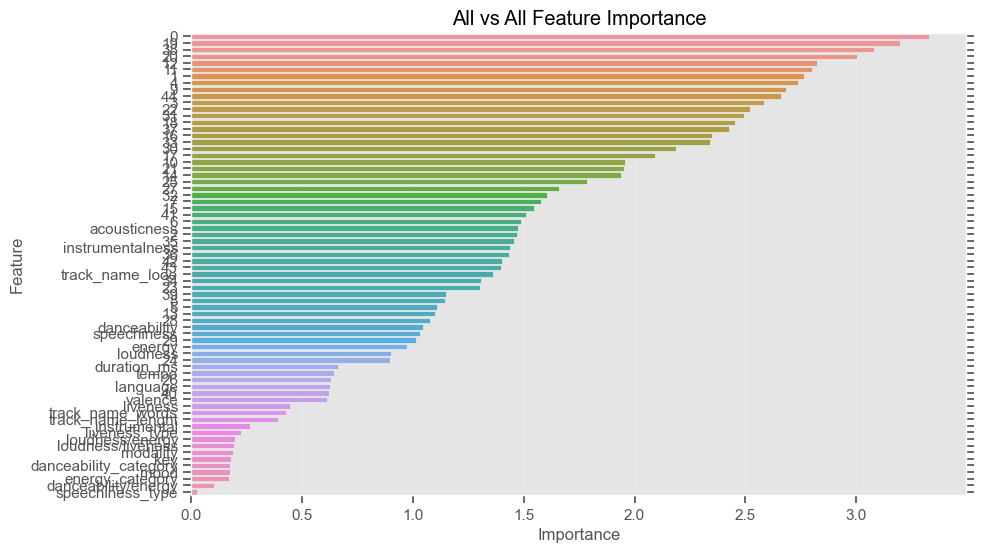

In [177]:
results = list(zip(train_ens, clf.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
se.barplot(x = importance.Importance, y = importance.Feature)
plt.title("All vs All Feature Importance")

### Creat Submition

In [ ]:
test1 = test.copy()

In [ ]:
test1.set_index('instance_id', drop=True, inplace=True)

In [ ]:
pred_test = []
res_columns = []

for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        res_columns.append(f'{columns[i]}_vs_{columns[j]}')
        pred_test.append(pvp_result[f'{columns[i]}_vs_{columns[j]}'].predict_proba(test1)[:,1].T)

In [ ]:
test_ens = pd.DataFrame(np.array(pred_test).T)

In [ ]:
test_ens.index = test1.index

In [ ]:
test1 = pd.concat([test_ens, test1], axis=1)

In [ ]:
answer = pd.DataFrame(clf.predict(test1))
answer.index = test1.index
answer.columns = ['music_genre']

In [ ]:
answer.to_csv("14.csv")

In [ ]:
answer

## StackingClassifier

In [178]:
train_ens.columns = train_ens.columns.astype(str)
test_ens.columns = test_ens.columns.astype(str)

In [179]:
gb = GradientBoostingClassifier(random_state=0, learning_rate=0.1, n_estimators=100)

lgbm = LGBMClassifier(random_state=0, learning_rate=0.01, n_estimators=4000, num_leaves=10)

cat = CatBoostClassifier(n_estimators=2000, learning_rate=0.01, random_state=0, eval_metric= 'TotalF1:average=Macro')

In [181]:
estimators = [
              ('gb', gb),
              ('lgbm', lgbm),
              ('cat', cat),
             ]

stack_model = StackingClassifier(estimators=estimators, final_estimator = 0.01
                                 ,n_jobs =-1, verbose = False, passthrough=True)

stack_model.fit(train_ans, target_train)

InvalidParameterError: The 'final_estimator' parameter of StackingClassifier must be None or an object implementing 'fit'. Got 0.01 instead.

In [ ]:
make_classification_plots(stack_model.predict(test_ans), target_test, 'Stack_modelClassifier')

#### Create Submition

In [ ]:
test1 = test.copy()
test1.drop(columns='track_name', inplace=True)
test1.set_index('instance_id', drop=True, inplace=True)

In [ ]:
test_ans = classes_predict(test1, y_train, model_dict_LGBM)

In [ ]:
stack_model.predict(test_ans)

In [ ]:
answer = pd.DataFrame(stack_model.predict(test_ans))

In [ ]:
answer.index = test1.index
answer.columns = ['music_genre']

In [ ]:
answer.to_csv('19.csv')

In [ ]:
answer

# Вывод

В данной работе, было необходимо разработать модель для определения жанра музыки по имеющимся характеристикам. Задача относится к задаче многоклассовой класификации. Основная сложность была в генерации новых признаков для увеличения метрики. Использовались следующие модели:

    1)Многоклассовая классификация CatBoost  
    2)One vs All CatBoost  
    3)LGBM классификация  
    4)One vs All LGBM  
    5)One vs All CatBoost + One vs All LGBM  
    6)One vs All LGBM + StackingClassifier  
 
Наилучший разультат показала модель One vs All LGBM с максимальной метрикой 54 на тесте (10% обучающей выборки). Сильный прирост в метрике дало генерация признаков из названия трека: язык, число символов и классификация названия по жанрам. 